# Tritonlytics MultiTask Classification - Standard Themes Metadata

Experiments related to building a LM and multilabel classification model for survey comments captured in the Tritonlytics survey delivery system

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import sys
sys.path.append('..')

In [2]:
from fastai.text import *   # Quick accesss to NLP functionality
from fastai.callbacks import *

import pdb
from tritonlytics import Metrics as metrics_util, DataGeneration as dg_util, PandasUtil as pd_util
from tritonlytics.evaluation import *
from tritonlytics.callbacks import RocAucEvaluation

import dill as pickle

import spacy
spacy_en = spacy.load('en')
spacy_es = spacy.load('es')

# pandas and plotting config
import seaborn as sns
sns.set_style('whitegrid')

plt.rcParams['figure.figsize'] = (9,6)

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 100)

In [3]:
print(f'fastai version: {__version__}')

fastai version: 1.0.57


In [4]:
torch.cuda.set_device(1)
print(f'Using GPU #{torch.cuda.current_device()}')

Using GPU #1


## Utility methods

In [5]:
def convert_to_snakecase(name):
    s1 = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', name)
    return re.sub('([a-z0-9])([A-Z])', r'\1_\2', s1).lower().replace('__', '_') 

In [6]:
# https://drive.google.com/file/d/0B1yuv8YaUVlZZ1RzMFJmc1ZsQmM/view : apostrophe lookup dict
appos_regex_repl = {
    r"\baren't\b" : "are not",
    r"\bcan't\b" : "cannot",
    r"\bcouldn't\b" : "could not",
    r"\bdidn't\b" : "did not",
    r"\bdoesn't\b" : "does not",
    r"\bdon't\b" : "do not",
    r"\bhadn't\b" : "had not",
    r"\bhasn't\b" : "has not",
    r"\bhaven't\b" : "have not",
    r"\bhe'd\b" : "he would",
    r"\bhe'll\b" : "he will",
    r"\bhe's\b" : "he is",
    r"\bi'd\b" : "I would",
    r"\bi'd\b" : "I had",
    r"\bi'll\b" : "I will",
    r"\bi'm\b" : "I am",
    r"\bisn't\b" : "is not",
    r"\bits\b" : "it is",
    r"\bit's\b" : "it is",
    r"\bit'll\b" : "it will",
    r"\bi've\b" : "I have",
    r"\blet's\b" : "let us",
    r"\bmightn't\b" : "might not",
    r"\bmustn't\b" : "must not",
    r"\bshan't\b" : "shall not",
    r"\bshe'd\b" : "she would",
    r"\bshe'll\b" : "she will",
    r"\bshe's\b" : "she is",
    r"\bshouldn't\b" : "should not",
    r"\bthat's\b" : "that is",
    r"\bthere's\b" : "there is",
    r"\bthey'd\b" : "they would",
    r"\bthey'll\b" : "they will",
    r"\bthey're\b" : "they are",
    r"\bthey've\b" : "they have",
    r"\bwe'd\b" : "we would",
    r"\bwe're\b" : "we are",
    r"\bweren't\b" : "were not",
    r"\bwe've\b" : "we have",
    r"\bwhat'll\b" : "what will",
    r"\bwhat're\b" : "what are",
    r"\bwhat's\b" : "what is",
    r"\bwhat've\b" : "what have",
    r"\bwhere's\b" : "where is",
    r"\bwho'd\b" : "who would",
    r"\bwho'll\b" : "who will",
    r"\bwho're\b" : "who are",
    r"\bwho's\b" : "who is",
    r"\bwho've\b" : "who have",
    r"\bwon't\b" : "will not",
    r"\bwouldn't\b" : "would not",
    r"\byou'd\b" : "you would",
    r"\byou'll\b" : "you will",
    r"\byou're\b" : "you are",
    r"\byou've\b" : "you have",
    r"\b're\b" : " are",
    r"\bwasn't\b" : "was not",
    r"\bwe'll\b" : "will",
    r"\bdidn't\b" : "did not",
    r"\btryin'\b" : "trying"
}

In [7]:
# based on https://www.kaggle.com/prashantkikani/pooled-gru-with-preprocessing
emoji_str_repls = {
    "&lt;3": " love ",
    ":]" : " happy ",
    "=)" : " happy ",
    "8)": " happy ",
    ":-)": " happy ",
    ":)": " happy ",
    "(-:": " happy ",
    "(:": " happy ",
    ":&gt;": " happy ",
    ":')": " happy ",
    "(:" : " happy ",
    ":d": " laughing ",
    ":dd": " laughing ",
    ";-)" : " wink ",
    ";)": " wink ",
    ":p": " playful ",
    ":o" : " surprise ",
    ":-(": " sad ",
    ":(": " sad ",
    "=(" : " sad ",
    "):" : " sad ",
    ":/": " skeptical ",
    ":s": " skeptical ",
    ":-s": " skeptical ",
    "^^": " nervous ",
    "^_^": " nervous ",
    "-_-" : " shame ",
}

In [8]:
spelling_regex_repls = {
    # abbreviations
    r"\bacctg\b" : "acct",
    r"\badd'l\b" : "additional",
    r"\br\s\b": "are",
    r"\bu\s\b": "you ",
    r"\b\sm\s\b ": "am",
    r"'cause\b" : "because",
    r"\b(ha)+\b": "haha",
    r"\b(he)+\b": "haha",
    r"\bya+y\b": "yay",
    r"\bwa+y\b": "way",
    r"\bf'real\b" : "for real",
    r"\bgr8\b" : "great",
    r"\bintl\b" : "int'l",
    # common misspellings
    r"\bbailable\b" : "available",
    r"\babilty\b" : "ability",
    r"\babsolutly\b" : "absolutely",
    r"\babsoultely\b" : "absolutely",
    r"\bacces\b" : "access",
    r"\baccesability\b" : "accessibility",
    r"\baccesbility\b" : "accessibility",
    r"\baccesibility\b" : "accessibility",
    r"\baccessability\b" : "accessibility",
    r"\baccessbility\b" : "accessibility",
    r"\baccesable\b" : "accessible",
    r"\baccesible\b" : "accessible",
    r"\baccessable\b" : "accessible",
    r"\bacessible\b" : "accessible",
    r"\bassessable\b" : "availability",
    r"\baccidently\b" : "accidentally",
    r"\baccomadate\b" : "accommodate",
    r"\baccomdate\b" : "accommodate",
    r"\baccomidate\b" : "accommodate",
    r"\baccomodate\b" : "accommodate",
    r"\baccomadating\b" : "accommodating",
    r"\baccomidating\b" : "accommodating",
    r"\baccomodating\b" : "accommodating",
    r"\baccomadations\b" : "accommodations",
    r"\baccomodation\b" : "accommodation",
    r"\baccouting\b" : "accounting",
    r"\baccross\b" : "across",
    r"\badd'l\b" : "additional",
    r"\badditonal\b" : "additional",
    r"\baddtionally\b" : "additionally",
    r"\badminstration\b" : "administration",
    r"\badminstrative\b" : "administrative",
    r"\badminstrator\b" : "administrator",
    r"\badress\b" : "address",
    r"\badvancment\b" : "advancement",
    r"\badvertized\b" : "advertised",
    r"\bafforable\b" : "affordable",
    r"\bafordable\b" : "affordable",
    r"\bafterall\b" : "after all",
    r"\bafterhours\b" : "after hours",
    r"\baggresive\b" : "aggressive",
    r"\bagressive\b" : "aggressive",
    r"\bagressions\b" : "aggressions",
    r"\balittle\b" : "a little",
    r"\balll\b" : "all",
    r"\balloted\b" : "allotted",
    r"\ballthough\b" : "although",
    r"\balthought\b" : "although",
    r"\ballways\b" : "always",
    r"\balos\b" : "also",
    r"\balot\b" : "a lot",
    r"\balotted\b" : "allotted",
    r"\bammount\b" : "amount",
    r"\bammounts\b" : "amounts",
    r"\bamoung\b" : "among",
    r"\bamoungst\b" : "amongst",
    r"\bannouncment\b" : "announcement",
    r"\baparments\b" : "apartments",
    r"\bapparrel\b" : "apparel",
    r"\bappartment\b" : "apartment",
    r"\bappriciate\b" : "appreciate",
    r"\bassitance\b" : "assistance",
    r"\bassitant\b" : "assistant",
    r"\batleast\b" : "at least",
    r"\battentative\b" : "attentive",
    r"\battrocious\b" : "atrocious",
    r"\bavaiable\b" : "available",
    r"\bavaible\b" : "available",
    r"\bavailabe\b" : "available",
    r"\bavailble\b" : "available",
    r"\bavailiable\b" : "available",
    r"\bavailible\b" : "available",
    r"\bavaliable\b" : "available",
    r"\bavalible\b" : "available",
    r"\bavilable\b" : "available",
    r"\bavailiability\b" : "availability",
    r"\bavailabiltiy\b" : "availability",
    r"\bavailabilty\b" : "availability",
    r"\bavailablility\b" : "availability",
    r"\bavailablity\b" : "availability",
    r"\bavailibility\b" : "availability",
    r"\bavaliability\b" : "availability",
    r"\bavaliablity\b" : "availability",
    r"\bavalibility\b" : "availability",
    r"\bactivies\b" : "activities",
    r"\bactivites\b" : "activities",
    r"\bactualy\b" : "actually",
    r"\bacutally\b" : "actually",
    r"\bammenities\b" : "amenities",
    r"\bantoher\b" : "another",
    r"\bassitant\b" : "assistant",
    r"\baswell\b" : "as well",
    r"\baweful\b" : "awful",
    r"\bawfull\b" : "awful",
    r"\bawsome\b" : "awesome",
    r"\bbeacuse\b" : "because",
    r"\bbearly\b" : "barely",
    r"\bbeaurocracy\b" : "bureaucracy",
    r"\bbeaurocratic\b" : "bureaucratic",
    r"\bbecasue\b" : "because",
    r"\bbecuase\b" : "because",
    r"\bbecuse\b" : "because",
    r"\bbefor\b" : "before",
    r"\bbeggining\b" : "beginning",
    r"\bbegining\b" : "beginning",
    r"\bbeleive\b" : "believe",
    r"\bbelive\b" : "believe",
    r"\bbenificial\b" : "beneficial",
    r"\bbenifit\b" : "benefit",
    r'\bbugetary\b' : "budgetary",
    r'\bbuiding\b' : "building",
    r'\bbuidling\b' : "building",
    r'\bbuisness\b' : "business",
    r'\bbuliding\b' : "building",
    r"\bbureacracy\b" : "bureaucracy",
    r"\bburitto\b" : "burrito",
    r"\bbussiness\b" : "business",
    r"\bcalender\b" : "calendar",
    r"\bcan;t\b" : "can't",
    r"\bcasher\b" : "cashier",
    r'\bcatagories\b' : "categories",
    r'\bcatagory\b' : "category",
    r"\bcheapter\b" : "cheaper",
    r"\bcheeper\b" : "cheaper",
    r'\bclasss\b' : "clas",
    r'\bclassses\b' : "classes",
    r"\bcleaniness\b" : "cleanliness",
    r"\bcmapus\b" : "campus",
    r'\bcofee\b' : "coffee",
    r'\bcoffe\b' : "coffee",
    r'\bcollegue\b' : "colleague",
    r'\bcoment\b' : "comment",
    r'\bcoments\b' : "comments",
    r'\bcomming\b' : "coming",
    r'\bcommittment\b' : "commitment",
    r'\bcommment\b' : "comment",
    r'\bcommuication\b' : "communication",
    r'\bcommunter\b' : "commuter",
    r'\bcommunters\b' : "commuters",
    r'\bcomotion\b' : "commotion",
    r'\bcomparision\b' : "comparison",
    r'\bcompatability\b' : "compatibility",
    r'\bcompatable\b' : "compatible",
    r'\bcompetative\b' : "competitive",
    r'\bcompetetive\b' : "competitive",
    r'\bcompetive\b' : "competitive",
    r'\bcompletly\b' : "completely",
    r"\bcomraderie\b" : "camaraderie",
    r'\bcomradery\b' : "camaraderie",
    r'\bcomunication\b' : "communication",
    r'\bcomunity\b' : "community",
    r'\bconcious\b' : "conscious",
    r'\bcondusive\b' : "conducive",
    r'\bconection\b' : "connection",
    r"\bconfortable\b" : "comfortable",
    r'\bconsistant\b' : "consistent",
    r'\bconsistantly\b' : "consistently",
    r'\bconsistenly\b' : "consistently",
    r'\bcontinously\b' : "continuously",
    r'\bcontruction\b' : "construction",
    r'\bconveinent\b' : "convenient",
    r'\bconveinient\b' : "convenient",
    r'\bconveniant\b' : "convenient",
    r'\bconveniece\b' : "convenience",
    r'\bconveninent\b' : "convenient",
    r'\bconvienance\b' : "convenience",
    r'\bconvienant\b' : "convenient",
    r'\bconvience\b' : "convenience",
    r'\bconvienence\b' : "convenience",
    r'\bconvienent\b' : "convenient",
    r'\bconvienet\b' : "convenient",
    r'\bconvienience\b' : "convenience",
    r'\bconvienient\b' : "convenient",
    r'\bconvient\b' : "convenient",
    r'\bconviently\b' : "conveniently",
    r'\bconvinence\b' : "convenience",
    r'\bconvinent\b' : "convenient",
    r'\bconvinience\b' : "convenience",
    r'\bconvinient\b' : "convenient",
    r'\bcorteous\b' : "courteous",
    r'\bcostodial\b' : "custodial",
    r'\bcoureous\b' : "courteous",
    r'\bcourtis\b' : "courteous",
    r'\bcouteous\b' : "courteous",
    r'\bcovenient\b' : "convenient",
    r'\bcroweded\b' : "crowded",
    r'\bcurteous\b' : "courteous",
    r'\bcurtesy\b' : "courtesy",
    r'\bcurtious\b' : "courteous",
    r"\bdeaprtment\b" : "department",
    r"\bdecission\b" : "decision",
    r'\bdefinately\b' : "definitely",
    r'\bdefinetely\b' : "definitely",
    r'\bdefinetly\b' : "definitely",
    r'\bdefinitley\b' : "definitely",
    r'\bdefinitly\b' : "definitely",
    r'\bdelievered\b' : "delivered",
    r'\bdeliverers\b' : "deliveries",
    r'\bdeparment\b' : "department",
    r'\bdeparments\b' : "department",
    r'\bdepartement\b' : "department",
    r"\bdepartment\(s\b" : "departments",
    r'\bdepartmet\b' : "department",
    r'\bdepratment\b' : "department",
    r"\bdeptartment\b" : "department",
    r'\bdescrimination\b' : "discrimination",
    r'\bdesireable\b' : "desirable",
    r"\bdiffernt\b" : "different",
    r"\bdiffrent\b" : "different",
    r'\bdinig\b' : "dining",
    r'\bdirverse\b' : "diverse",
    r'\bdisapointed\b' : "disappointed",
    r'\bdisapointing\b' : "disappointing",
    r'\bdisasterous\b' : "disastrous",
    r'\bdisatisfied\b' : "dissatisfied",
    r'\bdisbursment\b' : "disbursement",
    r'\bdisbursments\b' : "disbursements",
    r'\bdiscretely\b' : "discreetly",
    r'\bdiscusting\b' : "disgusting",
    r'\bdisfunctional\b' : "dysfunctional",
    r'\bdispensors\b' : "dispensers",
    r'\bdispersement\b' : "disbursement",
    r'\bdissapointed\b' : "disappointed",
    r'\bdissapointing\b' : "disappointing",
    r'\bdissapointment\b' : "disappointment",
    r'\bdissappointed\b' : "disappointed",
    r'\bdissappointing\b' : "disappointing",
    r'\bdissatified\b' : "dissatisfied",
    r'\bdiveristy\b' : "diversity",
    r'\bdivison\b' : "division",
    r'\bdivsion\b' : "division",
    r"\bdoens't\b" : "doesn't",
    r"\bdoes't\b" : "doesn't",
    r"\bdoesn;t\b" : "doesn't",
    r"\bdon;t\b" : "don't",
    r'\bdonot\b' : "do not",
    r"\bdosen't\b" : "doesn't",
    r"\bdosent\b" : "doesn't",
    r'\bdumbells\b' : "dumbbells",
    r'\bdurring\b' : "during",
    r"\beatting\b" : "eating",
    r"\beduation\b" : "education",
    r'\beffeciency\b' : "efficiency",
    r'\beffecient\b' : "efficient",
    r'\befficency\b' : "efficiency",
    r'\befficent\b' : "efficient",
    r'\beffiecient\b' : "efficient",
    r'\beimplying\b' : "implying",
    r'\bembarassed\b' : "embarrassed",
    r'\bembarassing\b' : "embarrassing",
    r'\bembarassment\b' : "embarrassment",
    r'\bemploee\b' : "employee",
    r'\bemploye\b' : "employee",
    r'\bemployee\(s\b' : "employees",
    r'\bemployeed\b' : "employed",
    r'\bemployement\b' : "employment",
    r'\bemployes\b' : "employees",
    r'\bemployess\b' : "employees",
    r'\bemplyee\b' : "employee",
    r'\bemplyees\b' : "employees",
    r'\bempolyees\b' : "employees",
    r'\bencoutered\b' : "encountered",
    r'\benought\b' : "enough",
    r'\benrollement\b' : "enrollment",
    r'\benviorment\b' : "environment",
    r'\benviornment\b' : "environment",
    r'\benvirnment\b' : "environment",
    r'\benviroment\b' : "environment",
    r'\benvironement\b' : "environment",
    r'\bequiped\b' : "equipped",
    r'\bespcially\b' : "especially",
    r'\bespecailly\b' : "especially",
    r'\bespecialy\b' : "especially",
    r'\bespeically\b' : "especially",
    r"\besthetically\b" : "aesthetically ",
    r"\bethinicity\b" : "ethnicity",
    r"\bevaulation\b" : "evaluation",
    r"\beventhough\b" : "even though",
    r'\beverday\b' : "every day",
    r'\beverthing\b' : "everything",
    r'\beveryones\b' : "everyones",
    r'\beverythings\b' : "everythings",
    r'\beveryway\b' : "every way",
    r'\beveyone\b' : "everyone",
    r'\beveything\b' : "everything",
    r'\bevrything\b' : "everything",
    r'\bexcelent\b' : "excellent",
    r'\bexcellant\b' : "excellent",
    r'\bexellent\b' : "excellent",
    r'\bexhorbitant\b' : "exorbitant",
    r'\bexistance\b' : "existence",
    r'\bexpecially\b' : "especially",
    r'\bexpensice\b' : "expensive",
    r'\bexpereince\b' : "experience",
    r'\bexperiance\b' : "experience",
    r'\bexperince\b' : "experience",
    r'\bexpierence\b' : "experience",
    r'\bexpirence\b' : "experience",
    r'\bexplaination\b' : "explanation",
    r'\bexremely\b' : "extremely",
    r'\bextemely\b' : "extremely",
    r'\bextention\b' : "extension",
    r'\bextermely\b' : "extremely",
    r'\bextreamly\b' : "extremely",
    r'\bextrememly\b' : "extremely",
    r'\bextremly\b' : "extremely",
    r"\bfacilites\b" : "facilities",
    r'\bfacilties\b' : "facilities",
    r'\bfacilty\b' : "facility",
    r'\bfaculity\b' : "faculty",
    r'\bfacutly\b' : "faculty",
    r'\bfiancial\b' : "financial",
    r"\bfinacial\b" : "financial",
    r"\bfirendly\b" : "friendly",
    r'\bflexability\b' : "flexibility",
    r'\bflexibilty\b' : "flexibility",
    r'\bflexiblity\b' : "flexibility",
    r"\bflourescent\b" : "fluorescent",
    r'\bfreindly\b' : "friendly",
    r'\bfreqency\b' : "frequency",
    r'\bfreqent\b' : "frequent",
    r'\bfriednly\b' : "friendly",
    r'\bfrusterating\b' : "frustrating",
    r'\bfrusturating\b' : "frustrating",
    r'\bfustrating\b' : "frustrating",
    r'\bgovenor\b' : "governor",
    r"\bgraffitti\b" : "graffiti",
    r"\bgrafitti\b" : "graffiti",
    r"\bgreatful\b" : "grateful",
    r"\bguarenteed\b" : "guaranteed",
    r"\bguidlines\b" : "guidelines",
    r"\bguranteed\b" : "guaranteed",
    r"\bhappend\b" : "happened",
    r'\bharrass\b' : "harass",
    r'\bharrassed\b' : "harassed",
    r'\bharrassing\b' : "harassing",
    r'\bharrassment\b' : "harassment",
    r"\bhavn't\b" : "haven't",
    r'\bhealtheir\b' : "healthier",
    r'\bhealthly\b' : "healthy",
    r'\bhealtier\b' : "healthier",
    r'\bhealty\b' : "healthy",
    r'\bheathy\b' : "healthy",
    r'\bheirarchy\b' : "hierarchy",
    r'\bhelful\b' : "helpful",
    r'\bhelpfull\b' : "helpful",
    r'\bhelpul\b' : "helpful",
    r'\bhighschool\b' : "high school",
    r'\bhighschools\b' : "high schools",
    r'\bhorendous\b' : "horrendous",
    r'\bhorible\b' : "horrible",
    r'\bhouseing\b' : "housing",
    r'\bi"m\b' : "i'm",
    r'\bi"ve\b' : "i've",
    r'\bimplimented\b' : "implemented",
    r'\bimporve\b' : "improve",
    r'\bimposible\b' : "impossible",
    r'\bimprovment\b' : "improvement",
    r'\bimprovments\b' : "improvements",
    r'\bincompetant\b' : "incompetent",
    r'\binconsistant\b' : "inconsistent",
    r'\binconveinent\b' : "nconvenient",
    r'\binconvience\b' : "inconvenience",
    r'\binconvienent\b' : "nconvenient",
    r'\binconvienient\b' : "nconvenient",
    r'\binconvient\b' : "nconvenient",
    r'\binconvinient\b' : "nconvenient",
    r'\bindentify\b' : "identify",
    r'\bindependant\b' : "independent",
    r'\bindividual\(s\b' : "individuals",
    r'\binforced\b' : "enforced",
    r'\binformaiton\b' : "information",
    r'\binformtion\b' : "information",
    r'\binfront\b' : "in front",
    r'\binnout\b' : "in-n-out",
    r'\binsentive\b' : "incentive",
    r'\binsufficent\b' : "insufficient",
    r'\binterenet\b' : "internet",
    r'\binterent\b' : "internet",
    r'\bintermural\b' : "intramural",
    r'\bintramurals\b' : "intramurals",
    r'\binvironment\b' : "environment",
    r'\bissue\(s\b' : "issues",
    r'\bit;s\b' : "it's",
    r'\bitem\(s\b' : "items",
    r"\bjob\(s\b" : "jobs",
    r'\bknowledable\b' : "knowledgeable",
    r'\bknowledeable\b' : "knowledgeable",
    r'\bknowledegable\b' : "knowledgeable",
    r'\bknowledgable\b' : "knowledgeable",
    r'\bknowledgably\b' : "knowledgeably",
    r'\bknowledgeably\b' : "knowledgeably",
    r'\bknowledgeble\b' : "knowledgeable",
    r'\bknowlegable\b' : "knowledgeable",
    r'\bknowlegeable\b' : "knowledgeable",
    r'\bliek\b' : "like",
    r'\blieke\b' : "like",
    r'\blimted\b' : "limited",
    r'\bmaintainance\b' : "maintenance",
    r'\bmaintaince\b' : "maintenance",
    r'\bmaintainence\b' : "maintenance",
    r'\bmaintanance\b' : "maintenance",
    r'\bmaintance\b' : "maintenance",
    r'\bmaintanence\b' : "maintenance",
    r'\bmaintenace\b' : "maintenance",
    r'\bmaintenances\b' : "maintenance",
    r'\bmaintence\b' : "maintenance",
    r'\bmaintenece\b' : "maintenance",
    r'\bmaintenence\b' : "maintenance",
    r'\bmaitenance\b' : "maintenance",
    r'\bmanager\(s\b' : "managers",
    r'\bmanagment\b' : "management",
    r'\bmanangement\b' : "management",
    r'\bmangement\b' : "management",
    r'\bmangers\b' : "managers",
    r'\bmanuever\b' : "maneuver",
    r'\bmintues\b' : "minutes",
    r'\bmoblie\b' : "mobile",
    r'\bmulitple\b' : "multiple",
    r'\bn\?a\b' : "n/a",
    r'\bna\b' : "n/a",
    r'\bneccessary\b' : "necessary",
    r'\bnecesary\b' : "necessary",
    r'\bneedes\b' : "needs",
    r'\bneeed\b' : "need",
    r'\bnonexistant\b' : "nonexistent",
    r'\bnothig\b' : "nothing",
    r'\bnothjng\b' : "nothing",
    r'\bnoticable\b' : "noticeable",
    r'\bobsurd\b' : "absurd",
    r'\bocassional\b' : "occasional",
    r'\boccassion\b' : "occasion",
    r'\boccassional\b' : "occasional",
    r'\boccassionally\b' : "occasionally",
    r'\boccassions\b' : "occasions",
    r'\boccations\b' : "occasions",
    r'\boccurances\b' : "occurrences",
    r'\boccured\b' : "occurred",
    r'\boccuring\b' : "occurring",
    r'\boccurr\b' : "occur",
    r'\bofcourse\b' : "of course",
    r'\bofferred\b' : "offered",
    r'\bopinon\b' : "opinion",
    r'\bopitions\b' : "options",
    r'\boportunities\b' : "opportunities",
    r'\bopperation\b' : "operation",
    r'\boppertunities\b' : "opportunities",
    r'\boppinion\b' : "opinion",
    r'\bopportunites\b' : "opportunities",
    r'\bopportunties\b' : "opportunities",
    r'\boppotunities\b' : "opportunities",
    r'\boppurtunities\b' : "opportunities",
    r'\boppurtunity\b' : "opportunity",
    r'\borgnized\b' : "organized",
    r'\boutragous\b' : "outrageous",
    r'\bpage\(s\b' : "pages",
    r'\bpakages\b' : "packages",
    r'\bparkibg\b' : "parking",
    r'\bparkig\b' : "parking",
    r'\bparkign\b' : "parking",
    r'\bparkinglots\b' : "parking lots",
    r'\bpartime\b' : "part-time",
    r'\bparttime\b' : "part-time",
    r'\bpatroling\b' : "patrolling",
    r'\bpeopel\b' : "people",
    r'\bpermitt\b' : "permit",
    r'\bperson\(s\b' : "persons",
    r'\bpersonel\b' : "personnel",
    r'\bpersonell\b' : "personnel",
    r'\bpharamcy\b' : "pharmacy",
    r'\bpleasent\b' : "pleasant",
    r'\bplently\b' : "plenty",
    r'\bplesant\b' : "pleasant",
    r'\bpositon\b' : "position",
    r'\bposses\b' : "possess",
    r'\bpossition\b' : "position",
    r'\bpostion\b' : "position",
    r'\bpostions\b' : "positions",
    r'\bpostition\b' : "position",
    r'\bpostive\b' : "positive",
    r'\bpractioner\b' : "practitioner",
    r'\bpractioners\b' : "practitioners",
    r'\bprefered\b' : "preferred",
    r'\bpreferrably\b' : "preferably",
    r'\bpreform\b' : "perform",
    r'\bpreforming\b' : "performing",
    r'\bpricess\b' : "prices",
    r'\bpriciples\b' : "principles",
    r'\bpricy\b' : "pricey",
    r'\bprking\b' : "parking",
    r'\bproceedures\b' : "procedures",
    r'\bprocurment\b' : "procurement",
    r'\bprofessionaly\b' : "professionally",
    r'\bproffessional\b' : "professional",
    r'\bproffit\b' : "profit",
    r'\bprofitt\b' : "profit",
    r'\bprogam\b' : "program",
    r'\bpromissed\b' : "promised",
    r'\bpublically\b' : "publicly",
    r'\bqucik\b' : "quick",
    r'\bquestion\(s\b' : "questions",
    r'\bquestionaire\b' : "questionnaire",
    r'\breall\b' : "really",
    r'\brealy\b' : "really",
    r'\breccomend\b' : "recommend",
    r'\breccommend\b' : "recommend",
    r'\breceieve\b' : "receive",
    r'\breciept\b' : "receipt",
    r'\breciepts\b' : "receipts",
    r'\brecieve\b' : "receive",
    r'\brecieved\b' : "received",
    r'\brecieves\b' : "receives",
    r'\brecieving\b' : "receiving",
    r'\brecived\b' : "received",
    r'\brecomend\b' : "recommend",
    r'\brecomended\b' : "recommended",
    r'\brediculous\b' : "ridiculous",
    r'\brediculously\b' : "ridiculously",
    r'\brefered\b' : "referred",
    r'\brefering\b' : "referring",
    r'\bregeants\b' : "regents",
    r'\bregistar\b' : "regisrtar",
    r'\bregistars\b' : "regisrtars",
    r'\bregulary\b' : "regularly",
    r'\breimbursment\b' : "reimbursement",
    r'\breponse\b' : "response",
    r'\breponsive\b' : "responsive",
    r'\brepresentitive\b' : "representative",
    r'\breserach\b' : "research",
    r'\bresonable\b' : "reasonable",
    r'\bresouces\b' : "resources",
    r'\bresourses\b' : "resources",
    r'\bresponsed\b' : "responded",
    r'\bresponsibilites\b' : "responsibilites",
    r'\bresponsiblities\b' : "responsibilites",
    r'\bresponsiblity\b' : "responsibility",
    r'\brestaraunts\b' : "restaurants",
    r'\brestraunts\b' : "restaurants",
    r'\brestuarant\b' : "restaurant",
    r'\brestuarants\b' : "restaurants",
    r'\bresturant\b' : "restaurant",
    r'\bresturants\b' : "restaurants",
    r'\bridiculus\b' : "ridiculous",
    r'\briduculous\b' : "ridiculous",
    r'\broomate\b' : "roommate",
    r'\broomates\b' : "roommates",
    r'\bsaleries\b' : "salaries",
    r'\bsandwhich\b' : "sandwich",
    r'\bsandwhiches\b' : "sandwiches",
    r'\bsandwitches\b' : "sandwiches",
    r'\bsatifaction\b' : "satisfaction",
    r'\bsatified\b' : "satisfisatisfieded",
    r'\bsattelite\b' : "satellite",
    r'\bsceience\b' : "science",
    r'\bschedual\b' : "schedule",
    r'\bseemless\b' : "seamless",
    r'\bselction\b' : "selection",
    r'\bsenority\b' : "seniority",
    r'\bsensative\b' : "sensitive",
    r'\bsensored\b' : "censored",
    r'\bseperate\b' : "separate",
    r'\bseperation\b' : "separation",
    r'\bserivce\b' : "service",
    r'\bserivces\b' : "services",
    r'\bserive\b' : "service",
    r'\bserives\b' : "services",
    r'\bservicesi\b' : "services",
    r'\bservidces\b' : "services",
    r'\bservive\b' : "survive",
    r'\bservives\b' : "survives",
    r'\bseverly\b' : "severely",
    r'\bsevice\b' : "service",
    r'\bsevices\b' : "services",
    r'\bshcool\b' : "school",
    r'\bshoud\b' : "should",
    r'\bshoudl\b' : "should",
    r'\bshutttle\b' : "shuttle",
    r'\bsimiliar\b' : "similar",
    r'\bsomeitmes\b' : "sometimes",
    r'\bsomeone\(s\b' : "someones",
    r'\bsomeones\b' : "someones",
    r'\bsometiems\b' : "sometimes",
    r'\bsomone\b' : "someone",
    r'\bsomthing\b' : "something",
    r'\bsophmore\b' : "sophomore",
    r'\bspecialy\b' : "especially",
    r'\bstafff\b' : "staff",
    r'\bstatment\b' : "statement",
    r'\bstong\b' : "strong",
    r'\bstongly\b' : "strongly",
    r'\bstoping\b' : "stopping",
    r'\bstrabucks\b' : "starbucks",
    r'\bstressfull\b' : "stressful",
    r'\bstructure\(s\b' : "structures",
    r'\bstucture\b' : "structure",
    r'\bstuctures\b' : "structures",
    r'\bstuden\b' : "student",
    r'\bstudent\(s\b' : "students",
    r'\bstudetns\b' : "students",
    r'\bstudnet\b' : "student",
    r'\bstudnets\b' : "students",
    r'\bsucess\b' : "success",
    r'\bsudent\b' : "student",
    r'\bsudents\b' : "students",
    r'\bsuperintendant\b' : "superintendent",
    r'\bsuperviser\b' : "supervisor",
    r'\bsupervisor\(s\b' : "supervisors",
    r'\bsupervisores\b' : "supervisors",
    r'\bsuport\b' : "support",
    r'\bsupples\b' : "supplies",
    r'\bsuppossed\b' : "supposed",
    r'\bsuprised\b' : "surprised",
    r'\bsuvey\b' : "survey",
    r'\bsytem\b' : "system",
    r'\bthats\b' : "that's",
    r"\bthe're\b" : "they're",
    r'\btheives\b' : "thieves",
    r'\bthiefs\b' : "thieves",
    r'\bthreating\b' : "threatening",
    r'\bthroughly\b' : "thoroughly",
    r'\bthrought\b' : "throughout",
    r'\bthroughtout\b' : "throughout",
    r'\btodays\b' : "today's",
    r'\btraing\b' : "training",
    r'\btrainning\b' : "training",
    r'\btranfers\b' : "transfers",
    r'\btransfered\b' : "transferred",
    r'\btransfering\b' : "transferring",
    r'\btransporation\b' : "transportation",
    r'\btransportaion\b' : "transportation",
    r'\btransportations\b' : "transportations",
    r'\btransportion\b' : "transportation",
    r'\btrashbags\b' : "trash bags",
    r'\btrashcans\b' : "trash cans",
    r'\btremedously\b' : "tremendously",
    r'\btshirt\b' : "t-shirt",
    r'\btshirts\b' : "t-shirts",
    r'\btution\b' : "tuition",
    r'\btutition\b' : "tuition",
    r'\bunaccessible\b' : "inaccessible",
    r'\bunconvenient\b' : "inconvenient",
    r'\bunecessary\b' : "unnecessary",
    r'\bunflexible\b' : "inflexible",
    r'\bunforseen\b' : "unforeseen",
    r'\buniverisity\b' : "university",
    r'\buniveristy\b' : "university",
    r'\buniverity\b' : "university",
    r'\bunknowledgeable\b' : "unknowledgable",
    r'\bunneccessary\b' : "unnecessary",
    r'\bunrealiable\b' : "unreliable",
    r'\buntill\b' : "until",
    r'\bunversity\b' : "university",
    r'\buseability\b' : "usability",
    r'\busefull\b' : "useful",
    r'\bususally\b' : "usually",
    r'\bvaccum\b' : "vacuum",
    r'\bvaccuum\b' : "vacuum",
    r'\bvaction\b' : "vacation",
    r'\bvacume\b' : "vacuum",
    r'\bvariaty\b' : "variety",
    r'\bvarities\b' : "varieties",
    r'\bvarity\b' : "variety",
    r'\bvegeterian\b' : "vegetarian",
    r'\bvegitarian\b' : "vegetarian",
    r'\bvegitarians\b' : "vegetarians",
    r'\bvegtables\b' : "vegetables",
    r'\bventillation\b' : "ventilation",
    r'\bveriety\b' : "variety",
    r'\bvisted\b' : "visited",
    r'\bvistor\b' : "visitor",
    r'\bvistors\b' : "visitors",
    r'\bweeekends\b' : "weekends",
    r'\bwierd\b' : "weird",
    r'\bwirless\b' : "wireless",
    r'\bwithdrawl\b' : "withdrawal",
    r'\bwoudl\b' : "would",
    r"\bwoudn't\b" : "wouldn't",
    r"\bthier\b" : "their",
    r"\bappartments\b" : "apartments",
    r"\bbenifits\b" : "benefits",
    r"\bexistant\b" : "existent",
    r"\bsaftey\b" : "safety",
    r'\bdon"t\b' : "don't",
}

In [9]:
weirdchar_str_repls = {
    "#39;" : "'",   
    'amp;' : '&',   
    '#146;' : "'",   
    'nbsp;' : ' ',   
    '#36;' : '$',   
    '\\n' : "\n",   
    'quot;' : "'",   
    '’' : "'",   
    "´" : "'",
    "`" : "'",
    '`' : "'", 
    '´' : "'", 
    '“' : '"',   
    '”' : '"',   
    '<br />' : "\n",   
    '\\"' : '"',   
    '<unk>' : 'u_n',   
    ' @.@ ' : '.',   
    ' @-@ ' : '-',   
    '\\' : ' \\ ',   
    '•' : '-'
}

In [10]:
# does regex replace making the substitution the same case
def re_replace(word, replacement, text):
    def func(match):
        g = match.group()
        if g.islower(): return replacement.lower()
        if g.istitle(): return replacement.title()
        if g.isupper(): return replacement.upper()
        return replacement      
    
    return re.sub(word, func, text, flags=re.I)

# define regex and string replacements
re_repls = {}  # e.g., { **spelling_regex_repls } 
str_repls = {} # e.g., { **weirdchar_str_repls }

def make_replacements(t:str) -> str:
    # replace based on regexs (keeping case) and then strings
    for k, v in re_repls.items(): t = re_replace(k, v, t)
    for k, v in str_repls.items(): t = t.replace(k, t)
    return t

# ensure am|pm is considered it own token (7:00pm > 7:00 pm, 7am-10pm > 7 am - 10 pm))
def fix_ampm(t:str) -> str:
    re_ampm = re.compile(r'(\d+)(am|pm|am\-|pm\-|a\.m\.|p\.m\.|a\.m\.\-|p\.m\.\-)')    
    return re_ampm.sub(r'\1 \2 ', t)

# try to handle places where a new sentence doesn't begin with a space (e.g., I like dogs.I like cats)
# without breaking apart things like urls and emails
def fix_sentence_ends(t:str) -> str:
    re_sentend = re.compile(r'(?<!www)\.((?!com|edu|org|net|m\b)[a-zA-Z]+)(?!(@|\.(com|edu|org|net)))\b') 
    return re_sentend.sub(r'. \1 ', t)

# separate hyphen|tilde if it is at beginning of letter/digit
def fix_hyphenated_words(t:str) -> str:
    re_hypword = re.compile(r'\s(\-+|~+)([a-zA-Z0-9])')
    return re_hypword.sub(r' \1 \2', t)


# prepend custom tokenization rules to defaults
custom_tok_rules = defaults.text_pre_rules + [make_replacements, fix_ampm, fix_sentence_ends, fix_hyphenated_words]

# use this customized Tokenizer for qualitative data
tokenizer = Tokenizer(pre_rules=custom_tok_rules, special_cases=None)

## Configuration

In [11]:
# various default, LM, and classification paths
PATH = Path('../data')
CLEAN_DATA_PATH = Path('../data/clean')

LM_PATH = PATH/'lm'
CLS_PATH = PATH/'classification'
STANDARD_THEME_PATH = CLS_PATH/'standard_themes'
STANDARD_THEME_META_PATH = STANDARD_THEME_PATH/'meta'

(LM_PATH/'models').mkdir(parents=True, exist_ok=True)
(LM_PATH/'tmp').mkdir(exist_ok=True)

(STANDARD_THEME_META_PATH/'models').mkdir(parents=True, exist_ok=True)
(STANDARD_THEME_META_PATH/'tmp').mkdir(exist_ok=True)

In [12]:
# basic columns
lm_dtypes = { 
    'Id': int, 'QuestionAnsID': int, 'AnswerText': str, 'AnswerText_NonEnglish': str, 'Language': str,
    
    'SurveyID': int, 'SurveyTypeID': int, 'BenchmarkSurveyType': str, 'ClientId': str,'RspID': int,
    
    'QuestionCategoryAbbr': str, 'QuestionText': str, 'QuestionClass': str, 
    
    'QuestionCategoryID': float, 'QuestionReportAbbr': str, 'QuestionCategoryLabel': str, 
    'BenchmarkLevel1': str, 'BenchmarkLevel2': str, 'BenchmarkLevel3': str, 'ClientBenchmarkLevel': str,
    
    'GroupCode': float, 'GroupID': str, 
    'GroupLevel1Code': float, 'GroupLevel1Name': str,
    'GroupLevel2Code': float, 'GroupLevel2Name': str,
    'GroupLevel3Code': float, 'GroupLevel3Name': str,
    'GroupLevel4Code': float, 'GroupLevel4Name': str,
    'GroupLevel5Code': float, 'GroupLevel5Name': str,
    'GroupLevel6Code': float, 'GroupLevel6Name': str,
    'GroupLevel7Code': float, 'GroupLevel7Name': str,
    'GroupLevel8Code': float, 'GroupLevel8Name': str,
}

lm_dtypes_sc = { convert_to_snakecase(k):v for k,v in lm_dtypes.items() }

standard_theme_meta_dtypes = {
    'standard_theme_id': int,
    'theme': str,
    'url_friendly_theme': str,
    'theme_display_order': int,
    'avg_sentiment': float,
    'is_example': int
}

# date columns
date_cols = []
    

STANDARD_THEME_META_LABELS = list(standard_theme_meta_dtypes.keys())[-2:]

In [13]:
vocab = pickle.load(open(LM_PATH/'vocab.pkl', 'rb'))

In [14]:
len(vocab.itos)

39904

## Classifier

The classifier is basically a linear layer custom head on top of the LM backbone

In [15]:
chunksize = 24000

bptt, em_sz, nh, nl = 70, 400, 1150, 3
bsz = 80
wd = 1e-7

In [16]:
# define what text columns to use (can be multiple)
corpus_cols = ['theme', 'answer_text'] 

# define how to identify the text we are using for the LM
corpus_suf = '_multitask' #'_cleaned'

In [17]:
train_df = pd.read_csv(STANDARD_THEME_META_PATH/'train.csv')
valid_df = pd.read_csv(STANDARD_THEME_META_PATH/'test.csv')

Remove any rows whre the "corpus_cols" are nan

In [18]:
train_df.dropna(subset=corpus_cols, inplace=True)
valid_df.dropna(subset=corpus_cols, inplace=True)

In [19]:
STANDARD_THEME_META_LABELS

['avg_sentiment', 'is_example']

In [20]:
# list(set(train_df.theme.unique()))

In [21]:
# vocab.itos += [ item.lower() for item in list(set(train_df.theme.unique())) ]
# vocab.stoi = collections.defaultdict(int,{v:k for k,v in enumerate(vocab.itos)})

In [22]:
class MultiTaskFloatList(FloatList):
    def __init__(self, items:Iterator, n_classes:int=1, log:bool=False, classes:Collection=None, **kwargs):
        super().__init__(items, log, classes, **kwargs)
        self.c = n_classes

In [23]:
cls_processor = [
    TokenizeProcessor(tokenizer=tokenizer, chunksize=chunksize, mark_fields=True),
    NumericalizeProcessor(vocab=vocab)
]

data_clas = (ItemLists(path=STANDARD_THEME_META_PATH,
                     train=TextList.from_df(
                         train_df, path=STANDARD_THEME_META_PATH, cols=corpus_cols, processor=cls_processor),
                     valid=TextList.from_df(
                         valid_df, path=STANDARD_THEME_META_PATH, cols=corpus_cols, processor=cls_processor)
                    )
             .label_from_df(cols=STANDARD_THEME_META_LABELS, label_cls=partial(MultiTaskFloatList,n_classes=2))
             .databunch(bs=bsz)
          )

data_clas.save(f'data_cls_standard_theme_meta.pkl')

/home/wgilliam/anaconda3/envs/tritonlytics-ml/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type MSELoss. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [24]:
data_clas = load_data(STANDARD_THEME_META_PATH, f'data_cls_standard_theme_meta.pkl', bs=bsz)

In [25]:
print(data_clas.train_ds.x[0])
print(data_clas.train_ds.y[0])

xxbos xxfld 1 xxmaj supervisor xxmaj effectiveness / xxmaj resolves xxmaj staff xxmaj issues xxfld 2 xxmaj leaders need to be trained to be xxmaj leaders xxrep 4 . xxmaj leaders need to be in their departments to lead not in meetings xxup all day xxrep 4 . xxmaj leaders need to learn how to train and discipline xxrep 4 . xxmaj leaders need to learn how to handle conflict in the work place and discipline those who do n't comply with xxup ucsd and or xxmaj department policies
[1. 0.]


In [26]:
print(len(data_clas.train_ds), len(data_clas.train_ds.vocab.itos))
print(len(data_clas.valid_ds), len(data_clas.valid_ds.vocab.itos))

4619 39904
514 39904


In [27]:
it = iter(data_clas.train_dl)

In [28]:
batch = next(it)
print(batch[0].size())
print(batch[1].size())
print(batch[0].size(), batch[0].type(), batch[1].size(), batch[1].type(), bsz)

torch.Size([80, 486])
torch.Size([80, 2])
torch.Size([80, 486]) torch.cuda.LongTensor torch.Size([80, 2]) torch.cuda.FloatTensor 80


In [29]:
' '.join([ data_clas.train_ds.vocab.itos[idx] for idx in batch[0][0,:] ])

"xxbos xxfld 1 xxmaj ethical xxmaj conduct / xxmaj perform xxmaj responsibilities / xxmaj spirit of xxmaj cooperation xxfld 2 xxmaj in the xxmaj enterprise xxmaj network and xxmaj telecommunications group of xxup its , the environment continues to be toxic , retaliatory , abusive , and discriminatory as in past years . xxmaj under the direction of xxmaj james xxmaj seddon , supervisor xxmaj malerie xxmaj samadi harasses and talks down to employees . xxmaj manipulates and edits official documentation to make staff look and give lower performance appraisal ratings or retaliate against them . xxmaj also , use the same practice to provide their friends with higher performance ratings and award them with higher merit increases . xxmaj senior management continues to harbor this behavior without any consequence and or accountability . xxmaj james and xxmaj malerie exploit minorities and give preferential treatment to personnel hired by them . xxmaj regularly abuse the power that the xxmaj uni

In [30]:
data_clas.show_batch()

text,target
"xxbos xxfld 1 xxmaj ethical xxmaj conduct / xxmaj perform xxmaj responsibilities / xxmaj spirit of xxmaj cooperation xxfld 2 xxmaj in the xxmaj enterprise xxmaj network and xxmaj telecommunications group of xxup its , the environment continues to be toxic , retaliatory , abusive , and discriminatory as in past years . xxmaj under the direction of xxmaj james xxmaj seddon , supervisor xxmaj malerie xxmaj samadi harasses and",[1. 1.]
"xxbos xxfld 1 xxmaj supervisor xxmaj effectiveness / xxmaj resolves xxmaj staff xxmaj issues xxfld 2 xxmaj in the xxmaj enterprise xxmaj network and xxmaj telecommunications group of xxup its , the environment continues to be toxic , retaliatory , abusive , and discriminatory as in past years . xxmaj under the direction of xxmaj james xxmaj seddon , supervisor xxmaj malerie xxmaj samadi harasses and talks down to employees",[1. 0.]
"xxbos xxfld 1 xxmaj fear of xxmaj retaliation , xxmaj negative xxmaj consequences xxfld 2 xxmaj in the xxmaj enterprise xxmaj network and xxmaj telecommunications group of xxup its , the environment continues to be toxic , retaliatory , abusive , and discriminatory as in past years . xxmaj under the direction of xxmaj james xxmaj seddon , supervisor xxmaj malerie xxmaj samadi harasses and talks down to employees .",[1.5 0. ]
"xxbos xxfld 1 xxmaj favoritism / xxmaj cliques xxfld 2 xxmaj in the xxmaj enterprise xxmaj network and xxmaj telecommunications group of xxup its , the environment continues to be toxic , retaliatory , abusive , and discriminatory as in past years . xxmaj under the direction of xxmaj james xxmaj seddon , supervisor xxmaj malerie xxmaj samadi harasses and talks down to employees . xxmaj manipulates and edits official",[1. 0.]
"xxbos xxfld 1 xxmaj parking / xxmaj transportation xxfld 2 xxmaj insights as alumna / former student of xxup ucsd , working on main campus 3.5 + years , xxmaj mexican - xxmaj american female & varied experience from start - up to non - profit to corporate : \ r \n 1 . xxmaj dept / xxmaj culture : xxmaj all , not just leadership / xxup hr-",[2. 0.]


### Configure a forward or backwards run

In [23]:
backwards = True

m_suf = '_multitask' #'_cleaned'
m_pre = 'bwd_' if (backwards) else 'fwd_'

data_clas = load_data(STANDARD_THEME_META_PATH, f'data_cls_standard_theme_meta.pkl', bs=bsz, backwards=backwards)

### Build the classifier (baseline)

In [24]:
unique_is_example_vals = list(train_df.is_example.value_counts())
is_example_pos_weight = (np.max(unique_is_example_vals) / unique_is_example_vals)[1]

print(is_example_pos_weight)

71.171875


In [25]:
multitask_config = {
    'sentiment':  { 
        'type': 'regression', 'input_idxs': [0], 'target_idxs': [0], 
        'y_range': [1., 5.1],
        'loss_weight': 1.
    },
    'is_example': { 
        'type': 'binaryclass', 'input_idxs': [1], 'target_idxs': [1], 
        'y_range': None,
        'class_weights': torch.tensor([is_example_pos_weight]),
        'loss_weight': 0.1
    }
}

In [26]:
class MultiTaskClassifier(nn.Module):
    
    def __init__(self, config):
        super().__init__()
        self.config = config
    
    def forward(self, input):
        x, raw_outputs, outputs = input
        
        for k,v in self.config.items():
            outv = x[:, v['input_idxs']]
            if (v['y_range']): outv = self._constrain_range(outv, v['y_range'])
            x[:, v['input_idxs']] = outv
            
        return x, raw_outputs, outputs
    
    def _constrain_range(self, x, y_range):
        x = torch.sigmoid(x)
        x = x * (y_range[1] - y_range[0])
        x = x + y_range[0]
        return x

In [27]:
def MultiTaskLossFlat(*args, axis:int=-1, config=multitask_config, **kwargs):
    
    losses = []
    
    for k,v in config.items():
        input_targs = [args[0][:, v['input_idxs']], args[1][:, v['target_idxs']]]
        class_weights = v['class_weights'].to(input_targs[0].device) if ('class_weights' in v) else None
        
        if (v['type'] ==  'regression'): 
            loss = MSELossFlat(axis=axis, **kwargs)(*input_targs)
            
        elif (v['type'] ==  'multiclass'): 
            input_targs[1] = input_targs[1].long()
            loss = CrossEntropyFlat(weight=class_weights, axis=axis, **kwargs)(*input_targs)
            
        elif (v['type'] ==  'binaryclass'): 
            input_targs[1] = input_targs[1].long()
            if (v['y_range']):
                loss = BCEFlat(axis=axis, **kwargs)(*input_targs)
            else:
                loss = BCEWithLogitsFlat(pos_weight=class_weights, axis=axis, **kwargs)(*input_targs)
                
        elif (v['type'] ==  'multilabel'): 
            input_targs[1] = input_targs[1].long()
            if (v['y_range']):
                loss = BCEFlat(axis=axis, **kwargs)(*input_targs)
            else:
                loss = BCEWithLogitsFlat(pos_weight=class_weights, axis=axis, **kwargs)(*input_targs)
                
        losses.append(v['loss_weight'] * loss)
    
    return torch.sum(torch.stack(losses))

We setup the dropouts for the model - these values have been chosen after experimentation. If you need to update them for custom LMs, you can change the weighting factor (0.7 here) based on the amount of data you have. For more data, you can reduce dropout factor and for small datasets, you can reduce overfitting by choosing a higher dropout factor. *No other dropout value requires tuning*

We first tune the last embedding layer so that the missing tokens initialized with mean weights get tuned properly. So we freeze everything except the last layer.

We also keep track of the *accuracy* metric.

In [28]:
beta = 1
start = 0.1

def fscore(preds, targs):
    return metrics_util.best_fscore(preds, targs, beta, start=start)
    
def opt_th(preds, targs):
    return metrics_util.best_fthresh(preds, targs, beta=beta, start=start)

def multilbl_accuracy(preds, targs):
    return metrics_util.multi_accuracy(preds, targs, beta=beta, start=start)

def is_example_acc(preds, targs):
    return accuracy(preds[:, 1:2], targs[:, 1])

def sentiment_mse(preds, targs):
    return mse(preds[:, 0], targs[:, 0])

In [29]:
try: learn.purge(); learn = None; torch.cuda.empty_cache(); gc.collect();
except: pass

In [30]:
learn = text_classifier_learner(data_clas, arch=AWD_LSTM, pretrained=False,
                                drop_mult=0.5, bptt=bptt, lin_ftrs=[50], ps=[0.1],
                                alpha=2., beta=1.)

In [ ]:
x = dict(learn.model.named_modules())
# x['1.layers.6'].out_features=3
# x['1.layers'].add_module('multitask', MultiTaskClassifier(config=multitask_config))
learn.model.add_module('multitask', MultiTaskClassifier(config=multitask_config))

In [ ]:
# x = list(learn.model.modules())[-2]
# x
# x.out_features=3
# x.add_module('asdfasdf',nn.Linear(3,2,True))

In [ ]:
learn.clip = 25.
learn.loss_func = partial(MultiTaskLossFlat, config=multitask_config)
learn.metrics = [is_example_acc, sentiment_mse]

learn.model_dir = 'models'

In [34]:
best_model_cb = partial(SaveModelCallback, monitor='valid_loss', mode='min', name=f'{m_pre}cls_bestmodel{m_suf}')

learn.callback_fns.append(best_model_cb)
# learn.callback_fns.append(RocAucEvaluation)

In [35]:
# copied from /lm/models -> class/models (both fwd and bwd weights)
! cp {LM_PATH/'models/*_lm_enc.pth'} {STANDARD_THEME_META_PATH/'models/'}  

In [36]:
learn = learn.load_encoder(f'{m_pre}lm_enc')

In [113]:
best_model_path = STANDARD_THEME_META_PATH/f'models/{m_pre}cls_bestmodel{m_suf}*'
!rm {best_model_path}

In [114]:
# learn.model

In [115]:
lr = 5e-2
wd = 0.

In [116]:
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


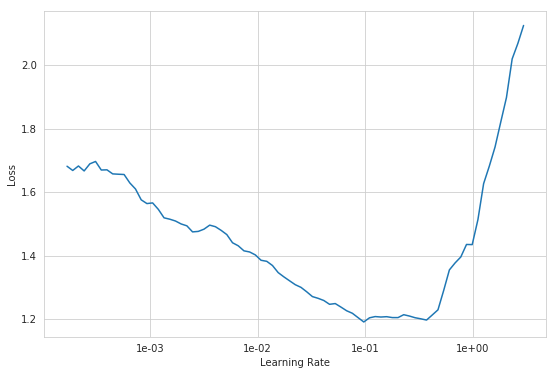

In [117]:
learn.lr_find(lr/1000, wd=wd)
learn.recorder.plot()

We set learning rates and fit our IMDB LM. We first run one epoch to tune the last layer which contains the embedding weights. This should help the missing tokens in the wikitext103 learn better weights.

In [118]:
%%time
learn.fit_one_cycle(1, lr, wd=wd)

epoch,train_loss,valid_loss,is_example_acc,sentiment_mse,time
0,0.982454,0.775768,0.988327,0.649911,00:09


Better model found at epoch 0 with valid_loss value: 0.7757678031921387.
CPU times: user 5.72 s, sys: 3.54 s, total: 9.26 s
Wall time: 9.51 s


In [119]:
learn.save(f'{m_pre}cls_last_ft{m_suf}')

In [120]:
# will load the best when training ends automaticall ... #learn = learn.load(f'{lm_pre}cls_last_ft{exp_suffix}')

In [121]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(5e-2/(2.6**4),5e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,is_example_acc,sentiment_mse,time
0,0.828432,0.654378,0.988327,0.540449,00:09


Better model found at epoch 0 with valid_loss value: 0.6543784141540527.


In [122]:
learn.save(f'{m_pre}cls_last2_ft{m_suf}')

In [123]:
# will load the best when training ends automaticall ... #learn = learn.load(f'{lm_pre}cls_last2_ft{exp_suffix}')

In [124]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,is_example_acc,sentiment_mse,time
0,0.661724,0.597494,0.988327,0.485003,00:13


Better model found at epoch 0 with valid_loss value: 0.5974938273429871.


In [125]:
learn.save(f'{m_pre}cls_last3_ft{m_suf}')

In [126]:
# will load the best when training ends automaticall ... 
# learn = learn.load(f'{lm_pre}cls_last3_ft{exp_suffix}')

In [127]:
learn.unfreeze()
learn.fit_one_cycle(10, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,is_example_acc,sentiment_mse,time
0,0.624796,0.586398,0.988327,0.475809,00:19
1,0.609390,0.589126,0.988327,0.482059,00:17
2,0.589414,0.576777,0.988327,0.467646,00:16
3,0.560704,0.571593,0.988327,0.461598,00:17
4,0.538916,0.572163,0.988327,0.462485,00:17
5,0.519013,0.572294,0.988327,0.454377,00:19
6,0.483885,0.580296,0.988327,0.460641,00:16
7,0.465552,0.597406,0.988327,0.474224,00:21
8,0.458753,0.585930,0.988327,0.465440,00:16
9,0.454602,0.585971,0.988327,0.463412,00:16


Better model found at epoch 0 with valid_loss value: 0.5863980650901794.
Better model found at epoch 2 with valid_loss value: 0.5767768621444702.
Better model found at epoch 3 with valid_loss value: 0.5715926885604858.


In [128]:
learn.save(f'{m_pre}cls{m_suf}')

Export model for inference

In [129]:
learn.export(file=f'{m_pre}export_clas{m_suf}.pkl')

/home/wgilliam/anaconda3/envs/tritonlytics-ml/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type SequentialRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/wgilliam/anaconda3/envs/tritonlytics-ml/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type MultiBatchEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/wgilliam/anaconda3/envs/tritonlytics-ml/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type AWD_LSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/wgilliam/anaconda3/envs/tritonlytics-ml/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for 

Use it for inference

In [130]:
inf_learn = load_learner(STANDARD_THEME_META_PATH, file=f'{m_pre}export_clas{m_suf}.pkl')

In [131]:
inf_learn.predict('EVERYTHING IS GOING SO GREAT! ')

(FloatItem [2.332911 3.71665 ],
 tensor([2.3329, 3.7167]),
 tensor([2.3329, 3.7167]))

Review final validation loss for best model

In [132]:
learn = learn.load(f'{m_pre}cls_bestmodel{m_suf}')
probs, targs, loss = learn.get_preds(DatasetType.Valid, with_loss=True)

print(f'Validation Loss: {loss / len(probs)}')

Validation Loss: 0.5715927481651306


In [133]:
for p, t in zip(probs,targs):
    print(p[0], p[1], torch.sigmoid(p[1]), t)

tensor(1.2693) tensor(3.0864) tensor(0.9563) tensor([1., 0.])
tensor(2.4261) tensor(-1.3441) tensor(0.2068) tensor([2., 0.])
tensor(2.0391) tensor(-0.3867) tensor(0.4045) tensor([1., 0.])
tensor(2.4052) tensor(-1.6456) tensor(0.1617) tensor([2., 0.])
tensor(2.6459) tensor(-0.8460) tensor(0.3003) tensor([3., 0.])
tensor(1.6674) tensor(0.4598) tensor(0.6130) tensor([1., 1.])
tensor(2.0687) tensor(-1.8093) tensor(0.1407) tensor([1., 0.])
tensor(2.0802) tensor(-1.3341) tensor(0.2085) tensor([2., 0.])
tensor(2.3332) tensor(-1.1854) tensor(0.2341) tensor([3., 0.])
tensor(2.2552) tensor(-1.8874) tensor(0.1315) tensor([3., 0.])
tensor(1.9742) tensor(-0.5663) tensor(0.3621) tensor([2., 0.])
tensor(1.9664) tensor(-0.5865) tensor(0.3574) tensor([2., 0.])
tensor(2.2708) tensor(-0.9960) tensor(0.2697) tensor([2., 0.])
tensor(2.0157) tensor(-2.1205) tensor(0.1071) tensor([2., 0.])
tensor(2.4358) tensor(-0.1824) tensor(0.4545) tensor([3., 0.])
tensor(1.8430) tensor(0.2637) tensor(0.5655) tensor([2., 

tensor(2.9854) tensor(-1.3714) tensor(0.2024) tensor([3., 0.])
tensor(1.8251) tensor(-1.0172) tensor(0.2656) tensor([2., 0.])
tensor(2.2822) tensor(-1.7469) tensor(0.1484) tensor([3., 0.])
tensor(2.1671) tensor(-0.9968) tensor(0.2696) tensor([2., 0.])
tensor(2.1244) tensor(-0.0216) tensor(0.4946) tensor([2., 0.])
tensor(2.8282) tensor(-1.2852) tensor(0.2167) tensor([3., 0.])
tensor(1.9838) tensor(-0.3485) tensor(0.4138) tensor([2., 0.])
tensor(2.2248) tensor(-0.2442) tensor(0.4393) tensor([3., 0.])
tensor(3.2460) tensor(-0.8022) tensor(0.3096) tensor([3., 0.])
tensor(2.4944) tensor(-1.2331) tensor(0.2256) tensor([2., 0.])
tensor(2.7837) tensor(-1.4499) tensor(0.1900) tensor([3., 0.])
tensor(2.3440) tensor(-0.5902) tensor(0.3566) tensor([1.5000, 0.0000])
tensor(2.1842) tensor(-0.1894) tensor(0.4528) tensor([3., 0.])
tensor(2.0348) tensor(-2.4259) tensor(0.0812) tensor([2., 0.])
tensor(1.7202) tensor(-1.4281) tensor(0.1934) tensor([1., 0.])
tensor(2.6180) tensor(-1.1958) tensor(0.2322) t

tensor(3.2656) tensor(-0.9109) tensor(0.2868) tensor([3., 0.])
tensor(3.9581) tensor(-0.2424) tensor(0.4397) tensor([5., 0.])
tensor(2.0720) tensor(-1.7484) tensor(0.1483) tensor([2., 0.])
tensor(1.6853) tensor(-1.3024) tensor(0.2138) tensor([3., 1.])
tensor(2.1772) tensor(-1.8125) tensor(0.1403) tensor([2., 0.])
tensor(2.4720) tensor(-0.2905) tensor(0.4279) tensor([1.5000, 0.0000])
tensor(2.6893) tensor(-0.8420) tensor(0.3011) tensor([2., 0.])
tensor(2.9753) tensor(-1.0998) tensor(0.2498) tensor([3., 0.])
tensor(2.1299) tensor(-1.7380) tensor(0.1496) tensor([2., 0.])
tensor(2.0650) tensor(-1.0885) tensor(0.2519) tensor([3., 0.])
tensor(3.8152) tensor(-0.7831) tensor(0.3137) tensor([5., 1.])
tensor(2.1983) tensor(-0.6109) tensor(0.3519) tensor([1., 0.])
tensor(2.5086) tensor(-1.3473) tensor(0.2063) tensor([2., 0.])
tensor(1.4399) tensor(-0.6985) tensor(0.3322) tensor([2., 0.])
tensor(4.5472) tensor(0.5534) tensor(0.6349) tensor([5., 0.])
tensor(3.5465) tensor(-0.9350) tensor(0.2819) te

tensor(1.8020) tensor(0.6058) tensor(0.6470) tensor([2., 0.])
tensor(3.8599) tensor(-0.6061) tensor(0.3529) tensor([4., 0.])
tensor(3.6116) tensor(-0.8003) tensor(0.3100) tensor([3., 0.])
tensor(1.4829) tensor(-1.0050) tensor(0.2680) tensor([2., 0.])
tensor(1.8048) tensor(-1.8067) tensor(0.1410) tensor([2., 0.])
tensor(1.4996) tensor(-1.8299) tensor(0.1383) tensor([2., 0.])
tensor(1.7925) tensor(0.6940) tensor(0.6668) tensor([2., 0.])
tensor(1.5287) tensor(0.3943) tensor(0.5973) tensor([1., 0.])
tensor(2.8418) tensor(-0.9546) tensor(0.2780) tensor([2., 0.])
tensor(1.8570) tensor(-0.5437) tensor(0.3673) tensor([2., 0.])
tensor(2.3657) tensor(-0.8524) tensor(0.2989) tensor([3., 0.])
tensor(2.6582) tensor(-1.1833) tensor(0.2345) tensor([2., 0.])
tensor(2.1500) tensor(0.2335) tensor(0.5581) tensor([2., 0.])
tensor(1.6417) tensor(0.4017) tensor(0.5991) tensor([2., 0.])
tensor(2.5278) tensor(-0.6239) tensor(0.3489) tensor([3., 0.])
tensor(4.1644) tensor(0.0567) tensor(0.5142) tensor([5., 0.]

In [134]:
print(STANDARD_THEME_META_LABELS)

['avg_sentiment', 'is_example']


In [135]:
learn.predict("plenty of parking available. found a spot every day I came to work. availability is solid")

(FloatItem [ 3.912143 -0.595983],
 tensor([ 3.9121, -0.5960]),
 tensor([ 3.9121, -0.5960]))

## Save models, csvs, to zip and download (optional)

In [136]:
from IPython.display import FileLink

In [137]:
# !zip -r models.zip {LM_PATH}/models/ {CLS_PATH}/models  -x {LM_PATH}/models/lstm_wt103/\*

# FileLink('models.zip')

In [138]:
# !zip verbatims-csvs.zip {PATH}/verbatims.csv {PATH}/verbatims-entities.csv {PATH}/verbatims-meta.csv

# FileLink('verbatims-csvs.zip')

## Review predictions

### Predict sentiment for our validation dataset, including the actual document

In [139]:
# predictions for a single model using the learner's model and data loaders
learn.load(f'{m_pre}cls_bestmodel{m_suf}')
learn.model.cuda(1)
probs, targs, loss = learn.get_preds(DatasetType.Valid, with_loss=True)

probs[:,1] = torch.sigmoid(probs[:,1])

probs.shape, targs.shape, loss / len(probs)

(torch.Size([514, 2]), torch.Size([514, 2]), tensor(0.5716))

In [140]:
??metrics_util.best_fthresh

In [141]:
data_clas.valid_ds.y.items.shape

(514, 2)

In [142]:
# determine optimal threshold based on desired f-score
is_example_threshold_f05 = metrics_util.best_fthresh(
    probs[:,1], targs[:,1], beta=0.5, start=0.5, end=.9, average='binary').item()
is_example_threshold_f1 = metrics_util.best_fthresh(
    probs[:,1], targs[:,1], beta=1, start=0.5, end=.9, average='binary').item()
is_example_threshold_f2 = metrics_util.best_fthresh(
    probs[:,1], targs[:,1], beta=2, start=0.5, end=.9, average='binary').item()

is_example_threshold_f05, is_example_threshold_f1, is_example_threshold_f2

(0.7599999904632568, 0.7599999904632568, 0.6100000143051147)

In [143]:
from sklearn import metrics

In [144]:
res = metrics.fbeta_score(targs[:,1], (probs[:,1] > is_example_threshold_f1), beta=1, average='binary')
res

0.2

In [145]:
preds = ((probs[:,1] > is_example_threshold_f1).byte() == targs[:,1].byte()).float().mean()
preds.item()

0.9688715934753418

In [146]:
# determine accuracy based on optimal threshold
is_example_val_acc_f05 = accuracy_thresh(probs[:,1], targs[:,1], is_example_threshold_f05, sigmoid=False).item()
is_example_val_acc_f1 = accuracy_thresh(probs[:,1], targs[:,1], is_example_threshold_f1, sigmoid=False).item()
is_example_val_acc_f2 = accuracy_thresh(probs[:,1], targs[:,1], is_example_threshold_f2, sigmoid=False).item()

is_example_val_acc_f05, is_example_val_acc_f1, is_example_val_acc_f2

(0.9688715934753418, 0.9688715934753418, 0.9357976913452148)

### Review classifier - Is Example

In [147]:
import sklearn
from sklearn import metrics
print (sklearn.__version__)

0.20.2


In [148]:
probs.shape, targs.shape

(torch.Size([514, 2]), torch.Size([514, 2]))

In [149]:
eval_targs = targs[:,1]
eval_probs = probs[:,1]

#### Classification Accuracy

The percentage of correct predictions.  Answers the question, *"Overall, how often is the classifier correct?"*

In [150]:
print(metrics.accuracy_score(eval_targs, (eval_probs > is_example_threshold_f1).float()))

0.9688715953307393


#### Null Accuracy
 
The accuracy achieved by always predicting the most frequent class.  Answers the question, *"What would the accuracy be by always predicting the most frequent case?"*

In [151]:
u_classes, u_counts = np.unique(eval_targs, return_counts=True)
most_freq_class, most_freq_class_count = u_classes[np.argmax(u_counts)], np.max(u_counts)
print(most_freq_class, most_freq_class_count)

0.0 508


In [152]:
most_freq_class_count / len(eval_targs)

0.9883268482490273

#### Cohen's kappa

This measure is intended to compare labelings by different human annotators (not a classifier vs. ground truth)

Kappa socres are between -1 and 1 ( >= .8 is generally considered good agreement; <= 0 means no agreement ... e.g., practically random labels)

In [153]:
print(metrics.cohen_kappa_score(eval_targs, (eval_probs > is_example_threshold_f1).float()))

0.18670886075949367


#### Confusion Matrix

Describes the performance of a classification model

In [154]:
def plot_confusion_matrix(cm, classes, normalize=False, 
                          title='Confusion matrix', cmap=plt.cm.Blues, print_info=False):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        if (print_info): print("Normalized confusion matrix")
    else:
        if (print_info): print('Confusion matrix, without normalization')

    if (print_info): print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar(fraction=0.046, pad=0.04)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.grid(None)

In [155]:
cm = metrics.confusion_matrix(eval_targs, (eval_probs > is_example_threshold_f1).float())

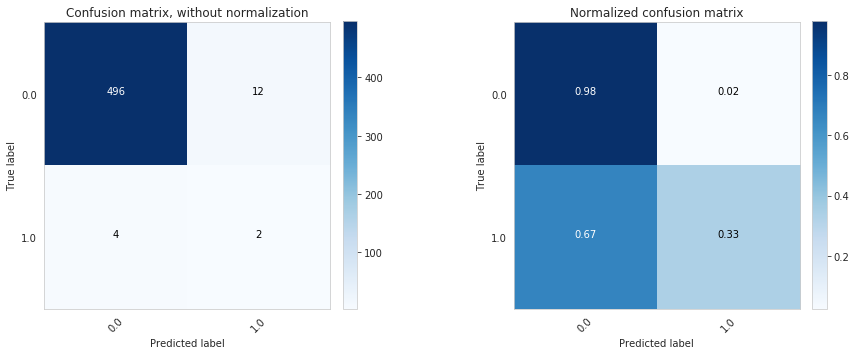

In [156]:
# Plot non-normalized confusion matrix
fig = plt.figure(figsize=(12,8))
plt.subplot(1, 2, 1)
plot_confusion_matrix(cm, classes=u_classes,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.subplot(1, 2, 2)
plot_confusion_matrix(cm, classes=u_classes, normalize=True,
                      title='Normalized confusion matrix')

fig.subplots_adjust(wspace=0.5)
plt.show()

In [157]:
print(metrics.classification_report(eval_targs, (eval_probs > is_example_threshold_f1).float(), [0,1]))

              precision    recall  f1-score   support

           0       0.99      0.98      0.98       508
           1       0.14      0.33      0.20         6

   micro avg       0.97      0.97      0.97       514
   macro avg       0.57      0.65      0.59       514
weighted avg       0.98      0.97      0.97       514



### Raw probability distribution

Useful to see how the threshold can be adjusted to increase sensitivity or specificity

Text(0, 0.5, 'Frequency')

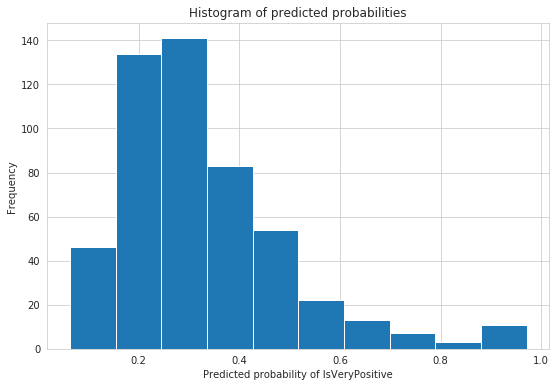

In [158]:
plt.hist(eval_probs, bins=10)
# plt.xlim(0,1)
plt.title('Histogram of predicted probabilities')
plt.xlabel('Predicted probability of IsVeryPositive')
plt.ylabel('Frequency')

Demonstrates how you can **decrease** the threshold for predicting label in order to **increase the sensitivity** of the classifier

#### ROC curves and Area Under the Curve (AUC)

***ROC Curve*** answers the question, *"How would sensitivity and specificity be affected by various thresholds without changing the threshold?"*  It is a way **to visualize the performance of a binary classifier.**

The ROC curve can help you **choose a threshold** that balances sensitivity and specificity based on your particular business case.

ROC curves visualize all possible classification thresholds whereas misclassification rate only represents your error rate for a single threshold.

A classifier that does a good job at separating the classes will have a ROC curve that hugs the upper left corner of the plot.  Converseley, a classifier the does a poor job separating the classes will have a ROC curve that is close to the diagonal line (0,0 -> 1,1).  That diagonal line represents a classifier that does no better than random guessing.

In [159]:
fpr, tpr, thresholds = metrics.roc_curve(eval_targs, eval_probs)

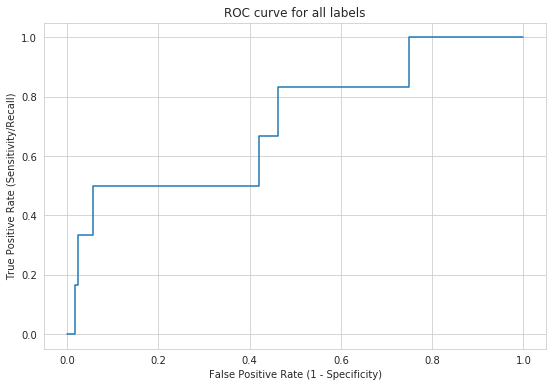

In [160]:
plt.plot(fpr, tpr)
plt.xlim = ([0.0, 1.0])
plt.ylim = ([0.0, 1.0])
plt.title('ROC curve for all labels')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity/Recall)')
plt.grid(True)

***AUC*** = the percentage of the ROC plot that is underneath the curve.  

AUC summarizes the performance of a classifier in a **single number**.  It says, *"If you randomly chose one positive and one negative observation, what is the likelihood that your classifier will assign a higher predicted probability to the positive observation."*

**An AUC of ~ 0.8 is very good while an AUC of ~ 0.5 represents a poor classifier.**

The ROC curve and AUC are insensitive to whether your predicted probabilities are properly calibrated to actually represent probabilities of class membership (e.g., it works if predicted probs range from 0.9 to 1 instead of 0 to 1).  All the AUC metric cares about is how well your classifier separated the two classes

Notes:
1.  AUC is useful even when there is **high class imbalance** (unlike classification accuracy)
2.  AUC is useful even when predicted probabilities are not properly calibrated (e.g., not between 0 and 1)

In [161]:
print(metrics.roc_auc_score(eval_targs, eval_probs))

0.7112860892388452


### Review classifier - Sentiment

In [162]:
# mse
metrics.mean_squared_error(targs[:,0], probs[:,0])

0.46159816

In [163]:
# rmse
math.sqrt(metrics.mean_squared_error(targs[:,0], probs[:,0]))

0.6794101543859132

In [164]:
# mae
metrics.mean_absolute_error(targs[:,0], probs[:,0])

0.5226906

### Ensemble forwards and backwards passes

In [75]:
try:
    learn_fwd.purge(); learn_fwd = None;
    learn_bwd.purge(); learn_bwd = None;
    gc.collect()
    torch.cuda.empty_cache()
except: pass


bsz = 80
m_suf = '_multitask'

learn_fwd = load_learner(STANDARD_THEME_META_PATH, file=f'fwd_export_clas{m_suf}.pkl')
data_fwd = load_data(STANDARD_THEME_META_PATH, f'data_cls_standard_theme_meta.pkl', bs=bsz)
learn_fwd.data = data_fwd

learn_bwd = load_learner(STANDARD_THEME_META_PATH, file=f'bwd_export_clas{m_suf}.pkl')
data_bwd = load_data(STANDARD_THEME_META_PATH, f'data_cls_standard_theme_meta.pkl', bs=bsz, backwards=True)
learn_bwd.data = data_bwd

In [76]:
probs_fwd, lbl_fwd, loss_fwd = learn_fwd.get_preds(ordered=False, with_loss=True)
probs_bwd, lbl_bwd, loss_bwd = learn_bwd.get_preds(ordered=False, with_loss=True)

probs_fwd[:,1] = torch.sigmoid(probs_fwd[:,1])
probs_bwd[:,1] = torch.sigmoid(probs_bwd[:,1])

probs_fwd.shape, probs_bwd.shape, loss_fwd.shape

(torch.Size([514, 2]), torch.Size([514, 2]), torch.Size([]))

In [77]:
loss_fwd/len(probs_fwd), loss_bwd/len(probs_fwd), (loss_fwd/len(probs_fwd) + loss_bwd/len(probs_fwd)) / 2

(tensor(0.5457), tensor(0.5716), tensor(0.5586))

In [78]:
probs_final = (probs_fwd + probs_bwd) / 2
# probs_final

#### Results

In [79]:
# determine optimal threshold based on desired f-score
is_example_threshold_f05 = metrics_util.best_fthresh(
    probs_fwd[:,1], lbl_fwd[:,1], beta=0.5, start=0.5, end=.9, average='binary').item()
is_example_threshold_f1 = metrics_util.best_fthresh(
    probs_fwd[:,1], lbl_fwd[:,1], beta=1, start=0.5, end=.9, average='binary').item()
is_example_threshold_f2 = metrics_util.best_fthresh(
    probs_fwd[:,1], lbl_fwd[:,1], beta=2, start=0.5, end=.9, average='binary').item()

is_example_threshold_f05, is_example_threshold_f1, is_example_threshold_f2

# determine accuracy based on optimal threshold
is_example_val_acc_f05 = accuracy_thresh(probs_fwd[:,1], lbl_fwd[:,1], is_example_threshold_f05, sigmoid=False).item()
is_example_val_acc_f1 = accuracy_thresh(probs_fwd[:,1], lbl_fwd[:,1], is_example_threshold_f1, sigmoid=False).item()
is_example_val_acc_f2 = accuracy_thresh(probs_fwd[:,1], lbl_fwd[:,1], is_example_threshold_f2, sigmoid=False).item()

is_example_val_acc_f05, is_example_val_acc_f1, is_example_val_acc_f2

print('Fowards Only\n-------------')
print(f'f05:\tOptimal threshold = {is_example_threshold_f05}\t(Accuracy = {is_example_val_acc_f05})')
print(f'f1:\tOptimal threshold = {is_example_threshold_f1}\t\t(Accuracy = {is_example_val_acc_f1})')
print(f'f2:\tOptimal threshold = {is_example_threshold_f2}\t(Accuracy = {is_example_val_acc_f2})')

print(f'\nAccuracy: {accuracy_thresh(probs_fwd[:,1], lbl_fwd[:,1], sigmoid=False)}')

Fowards Only
-------------
f05:	Optimal threshold = 0.7900000214576721	(Accuracy = 0.9649805426597595)
f1:	Optimal threshold = 0.7900000214576721		(Accuracy = 0.9649805426597595)
f2:	Optimal threshold = 0.7900000214576721	(Accuracy = 0.9649805426597595)

Accuracy: 0.8754863739013672


In [80]:
# determine optimal threshold based on desired f-score
is_example_threshold_f05 = metrics_util.best_fthresh(
    probs_bwd[:,1], lbl_bwd[:,1], beta=0.5, start=0.5, end=.9, average='binary').item()
is_example_threshold_f1 = metrics_util.best_fthresh(
    probs_bwd[:,1], lbl_bwd[:,1], beta=1, start=0.5, end=.9, average='binary').item()
is_example_threshold_f2 = metrics_util.best_fthresh(
    probs_bwd[:,1], lbl_bwd[:,1], beta=2, start=0.5, end=.9, average='binary').item()

is_example_threshold_f05, is_example_threshold_f1, is_example_threshold_f2

# determine accuracy based on optimal threshold
is_example_val_acc_f05 = accuracy_thresh(probs_bwd[:,1], lbl_bwd[:,1], is_example_threshold_f05, sigmoid=False).item()
is_example_val_acc_f1 = accuracy_thresh(probs_bwd[:,1], lbl_bwd[:,1], is_example_threshold_f1, sigmoid=False).item()
is_example_val_acc_f2 = accuracy_thresh(probs_bwd[:,1], lbl_bwd[:,1], is_example_threshold_f2, sigmoid=False).item()

is_example_val_acc_f05, is_example_val_acc_f1, is_example_val_acc_f2

print('Backwards Only\n-------------')
print(f'f05:\tOptimal threshold = {is_example_threshold_f05}\t(Accuracy = {is_example_val_acc_f05})')
print(f'f1:\tOptimal threshold = {is_example_threshold_f1}\t\t(Accuracy = {is_example_val_acc_f1})')
print(f'f2:\tOptimal threshold = {is_example_threshold_f2}\t(Accuracy = {is_example_val_acc_f2})')

print(f'\nAccuracy: {accuracy_thresh(probs_bwd[:,1], lbl_bwd[:,1], sigmoid=False)}')

Backwards Only
-------------
f05:	Optimal threshold = 0.7599999904632568	(Accuracy = 0.9688715934753418)
f1:	Optimal threshold = 0.7599999904632568		(Accuracy = 0.9688715934753418)
f2:	Optimal threshold = 0.6100000143051147	(Accuracy = 0.9357976913452148)

Accuracy: 0.8754863739013672


In [81]:
# determine optimal threshold based on desired f-score
is_example_threshold_f05 = metrics_util.best_fthresh(
    probs_final[:,1], lbl_bwd[:,1], beta=0.5, start=0.5, end=.9, average='binary').item()
is_example_threshold_f1 = metrics_util.best_fthresh(
    probs_final[:,1], lbl_bwd[:,1], beta=1, start=0.5, end=.9, average='binary').item()
is_example_threshold_f2 = metrics_util.best_fthresh(
    probs_final[:,1], lbl_bwd[:,1], beta=2, start=0.5, end=.9, average='binary').item()

is_example_threshold_f05, is_example_threshold_f1, is_example_threshold_f2

# determine accuracy based on optimal threshold
is_example_val_acc_f05 = accuracy_thresh(probs_final[:,1], lbl_bwd[:,1], is_example_threshold_f05, sigmoid=False).item()
is_example_val_acc_f1 = accuracy_thresh(probs_final[:,1], lbl_bwd[:,1], is_example_threshold_f1, sigmoid=False).item()
is_example_val_acc_f2 = accuracy_thresh(probs_final[:,1], lbl_bwd[:,1], is_example_threshold_f2, sigmoid=False).item()

is_example_val_acc_f05, is_example_val_acc_f1, is_example_val_acc_f2

print('Ensemble\n-------------')
print(f'f05:\tOptimal threshold = {is_example_threshold_f05}\t(Accuracy = {is_example_val_acc_f05})')
print(f'f1:\tOptimal threshold = {is_example_threshold_f1}\t\t(Accuracy = {is_example_val_acc_f1})')
print(f'f2:\tOptimal threshold = {is_example_threshold_f2}\t(Accuracy = {is_example_val_acc_f2})')

print(f'\nAccuracy: {accuracy_thresh(probs_final[:,1], lbl_bwd[:,1], sigmoid=False)}')

Ensemble
-------------
f05:	Optimal threshold = 0.7599999904632568	(Accuracy = 0.9649805426597595)
f1:	Optimal threshold = 0.7599999904632568		(Accuracy = 0.9649805426597595)
f2:	Optimal threshold = 0.7599999904632568	(Accuracy = 0.9649805426597595)

Accuracy: 0.8949416279792786


In [82]:
# sentiment metrics
sentiment_mae = metrics.mean_absolute_error(lbl_bwd[:,0], probs_final[:,0])
sentiment_mse = metrics.mean_squared_error(lbl_bwd[:,0], probs_final[:,0])
sentiment_rmse = math.sqrt(metrics.mean_squared_error(lbl_bwd[:,0], probs_final[:,0]))

print(sentiment_mae, sentiment_mse, sentiment_rmse)

tensor(0.5049) tensor(0.4342) 0.6589569619745712


In [83]:
final_valid_loss = (loss_fwd/len(probs_fwd) + loss_bwd/len(probs_fwd)) / 2
final_valid_loss

tensor(0.5586)

### Inference (ad-hoc documents)

In [84]:
print(STANDARD_THEME_META_LABELS)

['avg_sentiment', 'is_example']


In [85]:
test_comments = [
    'The parking situation REALLY sucks around here.  It needs to be fixed',
    'I LOVE working at UCSD!!!  It is wonderful',
    """Some staff are just uninformed.There is no support for solo-individual study (no closed off rooms).
        Once a guy (quite tall) walked in into the girl's restroom and used the stalls standing up. 
        There was no line in the guy's restroom. This happened when I done and was going to walk out. 
        I was extremely uncomfortable""",
    "I love UCSD!!! It is a terrible place to work!",
    "I was really uncomfortable to express my opinion!!!"
]

doc_probs, doc_preds, doc_toks = get_cls_doc_predictions(learn.model, vocab, tokenizer, test_comments, 
                                                         threshold=is_example_threshold_f1)

In [86]:
len(doc_probs), len(doc_probs), len(doc_toks)

(5, 5, 5)

In [87]:
for d_probs, d_preds, d_toks in zip(doc_probs, doc_preds, doc_toks):
    print(f'> {" ".join([t for t in d_toks])}\nProbabilities:\t{d_probs}\nPredictions:\t{d_preds}\n')

> xxmaj the parking situation xxup really sucks around here . xxmaj it needs to be fixed
Probabilities:	tensor([[3.0199, 0.0708]])
Predictions:	tensor([1., 0.])

> i xxup love working at xxup ucsd ! ! ! xxmaj it is wonderful
Probabilities:	tensor([[3.0176, 0.1215]])
Predictions:	tensor([1., 0.])

> xxmaj some staff are just uninformed . xxmaj there   is no support for solo - individual study ( no closed off rooms ) . 
  xxmaj once a guy ( quite tall ) walked in into the girl 's restroom and used the stalls standing up . 
  xxmaj there was no line in the guy 's restroom . xxmaj this happened when i done and was going to walk out . 
  i was extremely uncomfortable
Probabilities:	tensor([[3.0305, 0.1088]])
Predictions:	tensor([1., 0.])

> i love xxup ucsd ! ! ! xxmaj it is a terrible place to work !
Probabilities:	tensor([[3.0079, 0.1034]])
Predictions:	tensor([1., 0.])

> i was really uncomfortable to express my opinion ! ! !
Probabilities:	tensor([[3.0387, 0.0918]])
Predictions:	tensor(

### Inference (batch ensemble)

In [88]:
import datetime
yyyymmdd = datetime.date.today().strftime("%Y%m%d")

m_suf = '_multitask'

# device = torch.device('cpu')
device = torch.device('cuda:1') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda:1


In [89]:
verbatims_df = pd.read_csv(STANDARD_THEME_PATH/'saw/20191021_ensemble_predictions_multilabel.csv', 
                           dtype={**lm_dtypes}, parse_dates=[])

inf_df = verbatims_df.copy() #verbatims_df[test_df.SurveyID == 130].copy()
inf_df.reset_index(drop=True, inplace=True)
print(len(verbatims_df))

corpus_cols = ['theme', 'AnswerText'] 

37308


In [90]:
inf_df.head(1)

,Id,QuestionAnsID,AnswerText,AnswerText_NonEnglish,Language,SurveyID,SurveyTypeID,BenchmarkSurveyType,ClientId,RspID,QuestionCategoryAbbr,QuestionText,QuestionClass,QuestionCategoryID,QuestionReportAbbr,QuestionCategoryLabel,BenchmarkLevel1,BenchmarkLevel2,BenchmarkLevel3,ClientBenchmarkLevel,GroupCode,GroupID,GroupLevel1Code,GroupLevel1Name,GroupLevel2Code,GroupLevel2Name,GroupLevel3Code,GroupLevel3Name,GroupLevel4Code,GroupLevel4Name,GroupLevel5Code,GroupLevel5Name,GroupLevel6Code,GroupLevel6Name,GroupLevel7Code,GroupLevel7Name,GroupLevel8Code,GroupLevel8Name,prob_adequate_staffing,prob_advancement_and_training_opportunities,prob_appropriate_stress_work_assigned_equitably,prob_benefits,prob_better_ways_recognized_participate_in_decisions,prob_career_advancement,prob_committed_to_diversity,prob_communicates_essential_information,prob_ethical_conduct_perform_responsibilities_spirit_of_cooperation,prob_evaluated_fairly,prob_experienced_discrimination,prob_facilities_workspace_safety,prob_faculty_value_contributions,prob_favoritism_cliques,prob_fear_of_retaliation_negative_consequences,prob_feel_valued_by_department,prob_flexibility_work_life_balance,prob_good_use_of_skills,prob_have_necessary_tools,prob_have_voice_on_campus_valued_member_of_ucsd,prob_internal_processes_effective,prob_parking_transportation,prob_salary_pay,prob_satisfied_with_diversity_progams,prob_supervisor_effectiveness_resolves_staff_issues,pred_adequate_staffing,pred_advancement_and_training_opportunities,pred_appropriate_stress_work_assigned_equitably,pred_benefits,pred_better_ways_recognized_participate_in_decisions,pred_career_advancement,pred_committed_to_diversity,pred_communicates_essential_information,pred_ethical_conduct_perform_responsibilities_spirit_of_cooperation,pred_evaluated_fairly,pred_experienced_discrimination,pred_facilities_workspace_safety,pred_faculty_value_contributions,pred_favoritism_cliques,pred_fear_of_retaliation_negative_consequences,pred_feel_valued_by_department,pred_flexibility_work_life_balance,pred_good_use_of_skills,pred_have_necessary_tools,pred_have_voice_on_campus_valued_member_of_ucsd,pred_internal_processes_effective,pred_parking_transportation,pred_salary_pay,pred_satisfied_with_diversity_progams,pred_supervisor_effectiveness_resolves_staff_issues,threshold_f05,threshold_f1,threshold_f2,val_acc_f05,val_acc_f1,val_acc_f2,val_loss
0,69390,2576,no comment,NaN,English,110,9,SAW,UCSD,175922,EDI,If you would like to elaborate on any of your answers to the conduct and behavioral questions ab...,Verbatim,117.0,Conduct & Behavioral - Comments,EDI,None,None,None,1,455.0,3562,999999.0,UC San Diego,800.0,VICE CHANCELLOR CHIEF FINANCIAL OFFICER,818.0,"HOUSING, DINING, HOSPITALITY",444.0,FACILITIES AND BUILDING SERVICES TOTAL STAFF,455.0,"FACILITIES AND BUILDING SERVICES ALARMS, LOCK & KEY",NaN,NaN,NaN,NaN,NaN,NaN,0.001966,0.003236,0.007138,0.000055,0.000644,0.000236,0.001841,0.000519,0.006411,0.008533,0.000188,0.004777,0.000998,0.000224,0.015509,0.001519,0.00025,0.000111,0.000058,0.001251,0.000567,0.000108,0.002254,0.227842,0.013337,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.27,0.27,0.14,0.980913,0.980913,0.972199,0.079133


In [91]:
pred_theme_cols = filter_col = [col for col in inf_df if col.startswith('prob_')]
# pred_theme_cols

In [92]:
inf_df = inf_df.melt(id_vars=list(lm_dtypes.keys()) + ['threshold_f05', 'threshold_f1', 'threshold_f2', 'val_acc_f05', 'val_acc_f1', 'val_acc_f2', 'val_loss'], 
                     value_vars=pred_theme_cols, 
                     var_name='theme', 
                     value_name='theme_prob')
len(inf_df)

932700

In [93]:
inf_df = inf_df.loc[inf_df.theme_prob >= inf_df.threshold_f2]
len(inf_df)

69363

In [94]:
inf_df['url_friendly_theme'] = inf_df.theme.apply(
    lambda s: re.sub("(.*?)_([a-zA-Z])","\g<1> \g<2>",s).replace('prob', '').strip().title().replace(' ',''))

inf_df['theme'] = inf_df.url_friendly_theme.apply(lambda s: re.sub("([a-z])([A-Z])","\g<1> \g<2>",s))

In [95]:
inf_df.reset_index(inplace=True)

In [96]:
inf_df.head()

,index,Id,QuestionAnsID,AnswerText,AnswerText_NonEnglish,Language,SurveyID,SurveyTypeID,BenchmarkSurveyType,ClientId,RspID,QuestionCategoryAbbr,QuestionText,QuestionClass,QuestionCategoryID,QuestionReportAbbr,QuestionCategoryLabel,BenchmarkLevel1,BenchmarkLevel2,BenchmarkLevel3,ClientBenchmarkLevel,GroupCode,GroupID,GroupLevel1Code,GroupLevel1Name,GroupLevel2Code,GroupLevel2Name,GroupLevel3Code,GroupLevel3Name,GroupLevel4Code,GroupLevel4Name,GroupLevel5Code,GroupLevel5Name,GroupLevel6Code,GroupLevel6Name,GroupLevel7Code,GroupLevel7Name,GroupLevel8Code,GroupLevel8Name,threshold_f05,threshold_f1,threshold_f2,val_acc_f05,val_acc_f1,val_acc_f2,val_loss,theme,theme_prob,url_friendly_theme
0,7,144569,1877,We are at least five people down in my department and there are many who are carrying at least t...,NaN,English,120,9,SAW,UCSD,108611,SAT,"If you would like to elaborate on your responses above, or if you have any additional feedback r...",Verbatim,114.0,Comments re Work Environment at UCSD,Satisfaction with UC San Diego,None,None,None,1,NaN,2579,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.27,0.27,0.14,0.980913,0.980913,0.972199,0.079133,Adequate Staffing,0.373670,AdequateStaffing
1,8,424896,76290,Even when fully staffed there is much more work than can be done in a reasonable amount of time.,NaN,English,197,38,SAW,UCD,379967,NaN,"If you would like to elaborate on any of your responses to the questions above, please do so her...",NaN,NaN,Additional Comments,NaN,NaN,NaN,NaN,NaN,121000.0,4873,999999.0,UC Davis,100000.0,"Finance, Operations and Administration",120000.0,Administrative IT,121000.0,Client & Infrastructure Services,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.27,0.27,0.14,0.980913,0.980913,0.972199,0.079133,Adequate Staffing,0.827684,AdequateStaffing
2,18,187417,1877,My neutral or negative comments are not related to my department. Lack of funding for positions ...,NaN,English,121,9,SAW,UCSD,122425,SAT,"If you would like to elaborate on your responses above, or if you have any additional feedback r...",Verbatim,114.0,Comments re Work Environment at UCSD,Satisfaction with UC San Diego,None,None,None,1,NaN,1930,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.27,0.27,0.14,0.980913,0.980913,0.972199,0.079133,Adequate Staffing,0.626001,AdequateStaffing
3,35,581648,87097,Patrick Krug\r\nRobert Nissen,NaN,English,209,41,SAW-FACULTY,CSLA-Faculty,432197,NaN,Would you like to highlight a faculty or staff member who has made a particular impact on creati...,Verbatim,NaN,Recognize Colleague,NaN,NaN,NaN,NaN,NaN,NaN,5268,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.27,0.27,0.14,0.980913,0.980913,0.972199,0.079133,Adequate Staffing,0.292417,AdequateStaffing
4,37,590077,9439,"With so many new systems coming on board, it is integral to continue, and expand, communications...",NaN,English,212,9,SAW,UCSD,445617,None,The Standing Committee on Service and People Oriented Culture (SC-SPOC) is interested in learnin...,Verbatim,201.0,IdeaWave Comments,Other,None,None,None,1,10201.0,3441,999999.0,UC San Diego,10000.0,ACADEMIC AFFAIRS,10002.0,DIVISIONS/SCHOOLS,10004.0,BIOLOGICAL SCIENCES,10201.0,BIOLOGY - DEAN/ADMIN SUPPORT,NaN,NaN,NaN,NaN,NaN,NaN,0.27,0.27,0.14,0.980913,0.980913,0.972199,0.079133,Adequate Staffing,0.272820,AdequateStaffing


In [97]:
def get_classification_results(backwards:bool=False, m_suf:str='multilabel'):
    
    model_prefix = 'bwd' if backwards else 'fwd'
    
    # 1. grab learner, procs, and data
    inf_learn = load_learner(STANDARD_THEME_META_PATH, file=f'{model_prefix}_export_clas_{m_suf}.pkl')
    txt_procs = inf_learn.data.train_ds.processor
    inf_data = TextList.from_df(inf_df, cols=corpus_cols, processor=txt_procs).split_none().label_empty()
    
    # 2. define a suitable dataloader
    collate_fn = partial(pad_collate, pad_first=True, backwards=backwards)
    sampler = SortSampler(inf_data.train.x, key=[len(t) for t in inf_data.train.x.items].__getitem__)
    dl = DeviceDataLoader.create(inf_data.train, bs=128, sampler=sampler, collate_fn=collate_fn, device=device)
    
    # 3. get probs and document vectors
    inf_learn.model = inf_learn.model.to(device)
    inf_learn.model = inf_learn.model.eval()
    
    test_probs, doc_vecs, concat_doc_vecs = [], [], []
    with torch.no_grad():
        for index, (xb, yb) in enumerate(dl):
            if index % 1000 == 0:  print(index)

            # reset hidden state (if you don't do this you will OOM)
            inf_learn.model.reset()

            # why "detach"? the computation of gradients wrt the weights of netG can be fully 
            # avoided in the backward pass if the graph is detached where it is.
            probs, raw_outputs, outputs = inf_learn.model(xb)
            test_probs.append(to_detach(probs))


    all_probs = torch.cat(test_probs)

    # 4. ensure results are returned in order
    if hasattr(dl, 'sampler'):
        sampler_idxs = [i for i in dl.sampler]
        reverse_sampler = np.argsort(sampler_idxs)
        all_probs = all_probs[reverse_sampler]
        
    # 5. return ordered results
    inf_learn, inf_data = None, None; gc.collect()
    
    return all_probs

In [98]:
%time

probs_fwd = get_classification_results(backwards=False, m_suf='multitask')
probs_bwd = get_classification_results(backwards=True, m_suf='multitask')

probs_fwd[:,1] = torch.sigmoid(probs_fwd[:,1])
probs_bwd[:,1] = torch.sigmoid(probs_bwd[:,1])

probs_final = (probs_fwd + probs_bwd) / 2

print(probs_final.shape)
print(probs_fwd.shape)
print(probs_bwd.shape)

0
torch.Size([69363, 2])
torch.Size([69363, 2])
torch.Size([69363, 2])


Add the probabilities of each label to `inf_df`

In [99]:
prob_labels = ['prob_' + lbl for lbl in STANDARD_THEME_META_LABELS]
probs_df = pd.DataFrame(probs_final.numpy(), columns=prob_labels)
probs_df.head()

,prob_avg_sentiment,prob_is_example
0,2.495984,0.289978
1,2.847534,0.224968
2,2.388277,0.337524
3,3.723387,0.391268
4,2.927198,0.559345


In [100]:
# test_df_filtered.update(probs_df)
final_df = pd.concat([inf_df, probs_df], axis=1)
final_df.head()

,index,Id,QuestionAnsID,AnswerText,AnswerText_NonEnglish,Language,SurveyID,SurveyTypeID,BenchmarkSurveyType,ClientId,RspID,QuestionCategoryAbbr,QuestionText,QuestionClass,QuestionCategoryID,QuestionReportAbbr,QuestionCategoryLabel,BenchmarkLevel1,BenchmarkLevel2,BenchmarkLevel3,ClientBenchmarkLevel,GroupCode,GroupID,GroupLevel1Code,GroupLevel1Name,GroupLevel2Code,GroupLevel2Name,GroupLevel3Code,GroupLevel3Name,GroupLevel4Code,GroupLevel4Name,GroupLevel5Code,GroupLevel5Name,GroupLevel6Code,GroupLevel6Name,GroupLevel7Code,GroupLevel7Name,GroupLevel8Code,GroupLevel8Name,threshold_f05,threshold_f1,threshold_f2,val_acc_f05,val_acc_f1,val_acc_f2,val_loss,theme,theme_prob,url_friendly_theme,prob_avg_sentiment,prob_is_example
0,7,144569,1877,We are at least five people down in my department and there are many who are carrying at least t...,NaN,English,120,9,SAW,UCSD,108611,SAT,"If you would like to elaborate on your responses above, or if you have any additional feedback r...",Verbatim,114.0,Comments re Work Environment at UCSD,Satisfaction with UC San Diego,None,None,None,1,NaN,2579,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.27,0.27,0.14,0.980913,0.980913,0.972199,0.079133,Adequate Staffing,0.373670,AdequateStaffing,2.495984,0.289978
1,8,424896,76290,Even when fully staffed there is much more work than can be done in a reasonable amount of time.,NaN,English,197,38,SAW,UCD,379967,NaN,"If you would like to elaborate on any of your responses to the questions above, please do so her...",NaN,NaN,Additional Comments,NaN,NaN,NaN,NaN,NaN,121000.0,4873,999999.0,UC Davis,100000.0,"Finance, Operations and Administration",120000.0,Administrative IT,121000.0,Client & Infrastructure Services,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.27,0.27,0.14,0.980913,0.980913,0.972199,0.079133,Adequate Staffing,0.827684,AdequateStaffing,2.847534,0.224968
2,18,187417,1877,My neutral or negative comments are not related to my department. Lack of funding for positions ...,NaN,English,121,9,SAW,UCSD,122425,SAT,"If you would like to elaborate on your responses above, or if you have any additional feedback r...",Verbatim,114.0,Comments re Work Environment at UCSD,Satisfaction with UC San Diego,None,None,None,1,NaN,1930,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.27,0.27,0.14,0.980913,0.980913,0.972199,0.079133,Adequate Staffing,0.626001,AdequateStaffing,2.388277,0.337524
3,35,581648,87097,Patrick Krug\r\nRobert Nissen,NaN,English,209,41,SAW-FACULTY,CSLA-Faculty,432197,NaN,Would you like to highlight a faculty or staff member who has made a particular impact on creati...,Verbatim,NaN,Recognize Colleague,NaN,NaN,NaN,NaN,NaN,NaN,5268,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.27,0.27,0.14,0.980913,0.980913,0.972199,0.079133,Adequate Staffing,0.292417,AdequateStaffing,3.723387,0.391268
4,37,590077,9439,"With so many new systems coming on board, it is integral to continue, and expand, communications...",NaN,English,212,9,SAW,UCSD,445617,None,The Standing Committee on Service and People Oriented Culture (SC-SPOC) is interested in learnin...,Verbatim,201.0,IdeaWave Comments,Other,None,None,None,1,10201.0,3441,999999.0,UC San Diego,10000.0,ACADEMIC AFFAIRS,10002.0,DIVISIONS/SCHOOLS,10004.0,BIOLOGICAL SCIENCES,10201.0,BIOLOGY - DEAN/ADMIN SUPPORT,NaN,NaN,NaN,NaN,NaN,NaN,0.27,0.27,0.14,0.980913,0.980913,0.972199,0.079133,Adequate Staffing,0.272820,AdequateStaffing,2.927198,0.559345


Add in predictions based on f1 threshold

In [101]:
for lbl in STANDARD_THEME_META_LABELS[1:]:
    final_df[f'pred_{lbl}'] = (final_df[f'prob_{lbl}'] > is_example_threshold_f1).astype(np.int64)

Include found thresholds and metrics

In [102]:
final_df['is_example_threshold_f05'] = is_example_threshold_f05
final_df['is_example_threshold_f1'] = is_example_threshold_f1
final_df['is_example_threshold_f2'] = is_example_threshold_f2

final_df['is_example_val_acc_f05'] = is_example_val_acc_f05
final_df['is_example_val_acc_f1'] = is_example_val_acc_f1
final_df['is_example_val_acc_f2'] = is_example_val_acc_f2

In [103]:
final_df['sentiment_mae'] = sentiment_mae.item()
final_df['sentiment_mse'] = sentiment_mse.item()
final_df['sentiment_rmse'] = sentiment_rmse

In [104]:
final_df['val_loss_metadata'] = final_valid_loss.item()

In [105]:
final_df.head()

,index,Id,QuestionAnsID,AnswerText,AnswerText_NonEnglish,Language,SurveyID,SurveyTypeID,BenchmarkSurveyType,ClientId,RspID,QuestionCategoryAbbr,QuestionText,QuestionClass,QuestionCategoryID,QuestionReportAbbr,QuestionCategoryLabel,BenchmarkLevel1,BenchmarkLevel2,BenchmarkLevel3,ClientBenchmarkLevel,GroupCode,GroupID,GroupLevel1Code,GroupLevel1Name,GroupLevel2Code,GroupLevel2Name,GroupLevel3Code,GroupLevel3Name,GroupLevel4Code,GroupLevel4Name,GroupLevel5Code,GroupLevel5Name,GroupLevel6Code,GroupLevel6Name,GroupLevel7Code,GroupLevel7Name,GroupLevel8Code,GroupLevel8Name,threshold_f05,threshold_f1,threshold_f2,val_acc_f05,val_acc_f1,val_acc_f2,val_loss,theme,theme_prob,url_friendly_theme,prob_avg_sentiment,prob_is_example,pred_is_example,is_example_threshold_f05,is_example_threshold_f1,is_example_threshold_f2,is_example_val_acc_f05,is_example_val_acc_f1,is_example_val_acc_f2,sentiment_mae,sentiment_mse,sentiment_rmse,val_loss_metadata
0,7,144569,1877,We are at least five people down in my department and there are many who are carrying at least t...,NaN,English,120,9,SAW,UCSD,108611,SAT,"If you would like to elaborate on your responses above, or if you have any additional feedback r...",Verbatim,114.0,Comments re Work Environment at UCSD,Satisfaction with UC San Diego,None,None,None,1,NaN,2579,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.27,0.27,0.14,0.980913,0.980913,0.972199,0.079133,Adequate Staffing,0.373670,AdequateStaffing,2.495984,0.289978,0,0.76,0.76,0.76,0.964981,0.964981,0.964981,0.504937,0.434224,0.658957,0.55863
1,8,424896,76290,Even when fully staffed there is much more work than can be done in a reasonable amount of time.,NaN,English,197,38,SAW,UCD,379967,NaN,"If you would like to elaborate on any of your responses to the questions above, please do so her...",NaN,NaN,Additional Comments,NaN,NaN,NaN,NaN,NaN,121000.0,4873,999999.0,UC Davis,100000.0,"Finance, Operations and Administration",120000.0,Administrative IT,121000.0,Client & Infrastructure Services,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.27,0.27,0.14,0.980913,0.980913,0.972199,0.079133,Adequate Staffing,0.827684,AdequateStaffing,2.847534,0.224968,0,0.76,0.76,0.76,0.964981,0.964981,0.964981,0.504937,0.434224,0.658957,0.55863
2,18,187417,1877,My neutral or negative comments are not related to my department. Lack of funding for positions ...,NaN,English,121,9,SAW,UCSD,122425,SAT,"If you would like to elaborate on your responses above, or if you have any additional feedback r...",Verbatim,114.0,Comments re Work Environment at UCSD,Satisfaction with UC San Diego,None,None,None,1,NaN,1930,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.27,0.27,0.14,0.980913,0.980913,0.972199,0.079133,Adequate Staffing,0.626001,AdequateStaffing,2.388277,0.337524,0,0.76,0.76,0.76,0.964981,0.964981,0.964981,0.504937,0.434224,0.658957,0.55863
3,35,581648,87097,Patrick Krug\r\nRobert Nissen,NaN,English,209,41,SAW-FACULTY,CSLA-Faculty,432197,NaN,Would you like to highlight a faculty or staff member who has made a particular impact on creati...,Verbatim,NaN,Recognize Colleague,NaN,NaN,NaN,NaN,NaN,NaN,5268,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.27,0.27,0.14,0.980913,0.980913,0.972199,0.079133,Adequate Staffing,0.292417,AdequateStaffing,3.723387,0.391268,0,0.76,0.76,0.76,0.964981,0.964981,0.964981,0.504937,0.434224,0.658957,0.55863
4,37,590077,9439,"With so many new systems coming on board, it is integral to continue, and expand, communications...",NaN,English,212,9,SAW,UCSD,445617,None,The Standing Committee on Service and People Oriented Culture (SC-SPOC) is interested in learnin...,Verbatim,201.0,IdeaWave Comments,Other,None,None,None,1,10201.0,3441,999999.0,UC San Diego,10000.0,ACADEMIC AFFAIRS,10002.0,DIVISIONS/SCHOOLS,10004.0,BIOLOGICAL SCIENCES,10201.0,BIOLOGY - DEAN/ADMIN SUPPORT,NaN,NaN,NaN,NaN,NaN,NaN,0.27,0.27,0.14,0.980913,0.980913,0.972199,0.079133,Adequate Staffing,0.272820,AdequateStaffing,2.927198,0.559345,0,0.76,0.76,

In [106]:
import datetime
final_df.to_csv(STANDARD_THEME_META_PATH/f'{yyyymmdd}_ensemble_predictions{m_suf}.csv', index=False)

### Playground

In [107]:
print(final_df.iloc[0].is_example_threshold_f05)
print(final_df.iloc[0].is_example_threshold_f1)
print(final_df.iloc[0].is_example_threshold_f2)
print(final_df.prob_avg_sentiment.mean())

0.7599999904632568
0.7599999904632568
0.7599999904632568
2.9090850353240967


In [108]:
len(learn.layer_groups)

5

In [109]:
[ print(f'{lg}\n') for lg in learn.layer_groups ]

Sequential(
  (0): Embedding(39904, 400, padding_idx=1)
  (1): EmbeddingDropout(
    (emb): Embedding(39904, 400, padding_idx=1)
  )
)

Sequential(
  (0): WeightDropout(
    (module): LSTM(400, 1152, batch_first=True)
  )
  (1): RNNDropout()
)

Sequential(
  (0): WeightDropout(
    (module): LSTM(1152, 1152, batch_first=True)
  )
  (1): RNNDropout()
)

Sequential(
  (0): WeightDropout(
    (module): LSTM(1152, 400, batch_first=True)
  )
  (1): RNNDropout()
)

Sequential(
  (0): PoolingLinearClassifier(
    (layers): Sequential(
      (0): BatchNorm1d(1200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Dropout(p=0.2, inplace=False)
      (2): Linear(in_features=1200, out_features=50, bias=True)
      (3): ReLU(inplace=True)
      (4): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): Dropout(p=0.1, inplace=False)
      (6): Linear(in_features=50, out_features=2, bias=True)
    )
  )
)



[None, None, None, None, None]